# Final Project Submission

Please fill out:
* Student name: Deztany Jackson
* Student pace: DS Flex
* Scheduled project review date/time: March 30, 2023
* Instructor name: Morgan Jones
* Blog post URL: Dmvinedata.com

![Pnemonia Image](images/Pneumonia.jpeg)

# Summary

A local hospital wants to explore their image recognition options for pneumonia cases. Worldwide it is a deadly and expensive condition, especially for children and the elderly. Using Convultion Neural Networks, X-Ray images of Normal and Pneumonia patients, data scienties will attempt to build models that detect pneumonia with the goal of minimizing False Negatives (predicting no pneumonia, while there is). Because of the severity this is a main focus.
Data Understanding - Num of images and classification types...imbalance  Metrics Recall, Loss F1 primary, Accuracy
Data Prep - Train, Test Split, Rescaling... Data Augmentation
Modeling - Num of models, Hyperparameter tweeks: Batch Size, Epochs, Dropout, Activation, Learn Rate, Transfer, Data Augment
Evaluation - The best models were from with what parameters What were the metrics
Lime results - Edge Filters 
Conclusion- Simple, Recommendation

In [139]:
#Get a table of image info
#Check imports that are not used


Write a few sentences on the approach to Data Understanding

## Import Libraries

In [140]:
import os 
import glob 

#from google.colab import drive #Google Collab

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.metrics import Accuracy,Precision,Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import models, layers, optimizers, activations
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import  VGG19 #Pretrained Transfer Modeling
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score, f1_score, recall_score,accuracy_score, auc, log_loss
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, average_precision_score
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight 

import pathlib
import shutil

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')
tf.__version__

# Stop Tensorflow errors from showing especially 
import logging
tf.get_logger().setLevel(logging.ERROR)

# Showing the areas of the image boundaries
import lime
from lime import lime_base
from lime import lime_image
from skimage.segmentation import mark_boundaries

**The following modeling effort was developed on a Apple M2 Max 64GB computer. There may be tasks that may longer execute on other hardware**

# Data Understanding


The dataset is from Chest X-Ray of "Normal" and "Pneumonia" images from [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) with a total of 5856 .jpeg files. This data set is already broken up into three folders (train, validation and test) and a folder for each category ("NORMAL" or "PNEUMONIA"). 

<b> Original Dataset Splits 
- Train [1341 NORMAL, 3875 PNEUMONIA]
- Validation [8 NORMAL, 8 PNEUMONIA]
- Test [234 NORMAL, 390 PNEUMONIA]
    
There is a data imbalance between categories and splits. After the images are loaded, the Train and Validation images  are combined and then split 80/20 for each respective category (Normal, Pneumonia). This does not solve the data and split imbalance but improves the offset to support more accurate modeling evaluation metrics.

**The original dataset is already split by the time this notebook is turned it. The following code will still work with the original dataset and previously shifted images**    

## Loading Images

Images are loaded from the current directory joined with the location of the datset. The python "glob" module [Glob, Tara Boyle, 2021](https://towardsdatascience.com/the-python-glob-module-47d82f4cbd2d) is used to retrieve files recursively. Without knowing all the file names "*" astericks are used in place to get all fo the files.

In [141]:
#Get Current directory
cur_dir = os.getcwd()
cur_dir

'/Users/deztanyjackson/Documents/0_Flatiron/Phase_4/Project_4/Image_Classification_P4'

Understanding the total images split among the respective directories

In [142]:
#Retrieving dataset in the respective folders
train_data = glob.glob(os.path.join(cur_dir,'data/chest_xray/train/**/*.jpeg'))
val_data = glob.glob(os.path.join(cur_dir,'data/chest_xray/val/**/*.jpeg'))
test_data = glob.glob(os.path.join(cur_dir,'data/chest_xray/test/**/*.jpeg'))

#Printing total number of images in different directories
print(f"Training Set has: {len(train_data)} images")
print(f"Validation Set has: {len(val_data)} images")
print(f"Testing Set has: {len(test_data)} images")

Training Set has: 4534 images
Validation Set has: 698 images
Testing Set has: 624 images


Understanding the total categories (Normal and Pneumonia) split among the respective directories

Cite code Kaggle

In [143]:
DIR = "../chest_xray/"
sets = ["train", "val", "test"]
all_pneumonia = []
all_normal = []

for cat in sets:
    path = os.path.join(DIR, cat)
    norm = glob.glob(os.path.join(path, "NORMAL/*.jpeg"))
    pneu = glob.glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
    
    all_normal.extend(norm)
    all_pneumonia.extend(pneu)

print(f"Total Pneumonia Images: {len(all_pneumonia)}")
print(f"Total Normal Images: {len(all_normal)}")
print(f"Ratio of Normal/Pneumonia: {round(len(all_normal)/len(all_pneumonia),2)}")


Total Pneumonia Images: 4273
Total Normal Images: 1583
Ratio of Normal/Pneumonia: 0.37


The ratio of the Normal to Pneumonia images shows a total category imbalance.

---

### Initial Data Balancing 

The data splitting and moving will not solve the data imbalance for training, but supports better modeling metric evaluations. 
- Orinally started with 16 Validation Images
- Moving validation images to train set.
- Perform Random Train/Valid split 80/20 on Normal and Pneumonia images
- Move 20% of each back to validation folder

Retrieves Normal and Pneumonia specific images for each dataset

In [144]:
#Pulling in Normal and Pneumonia specific data 

#Training Data
t_norm = glob.glob(os.path.join(cur_dir,'data/chest_xray/train/NORMAL/*.jpeg'))
t_pneu = glob.glob(os.path.join(cur_dir,'data/chest_xray/train/PNEUMONIA/*.jpeg'))
#Validation Data
v_pneu = glob.glob(os.path.join(cur_dir,'data/chest_xray/val/PNEUMONIA/*.jpeg'))
v_norm = glob.glob(os.path.join(cur_dir,'data/chest_xray/val/NORMAL/*.jpeg'))
#Test Data
test_norm = glob.glob(os.path.join(cur_dir,'data/chest_xray/test/NORMAL/*.jpeg'))
test_pneu = glob.glob(os.path.join(cur_dir,'data/chest_xray/test/PNEUMONIA/*.jpeg'))

<b> Moving and Splitting Files (If Necessary)

Moving the validation data to the respective Normal and Pneumonia Training folders if the amount of files in the folders are less than 20 (This number is arbitrary). . If so, there will be a 80/20 split of the data and then the 20% of files are moved back to the respective Validation folder. The original dataset had 8 images per folder. The goal is to only move files if there is an huge value offset.  If not, then the files don't need to move.

In [228]:
if len(v_pneu) < 20 | len(v_norm) < 20: # Only perform action if valida
    #Moving Validation to Test
    cat = [v_norm,v_pneu]
    for c in cat:
        if c == v_norm:
            images = [f for f in v_norm if '.jpeg' in f.lower()] 
            for img in images:
                new_path = os.path.join(cur_dir,"data/chest_xray/train/NORMAL/")
                shutil.move(img,new_path)
        elif c == v_pneu:
            images = [f for f in v_pneu if '.jpeg' in f.lower()] 
            for img in images:
                new_path = os.path.join(cur_dir,"data/chest_xray/train/PNEUMONIA/")
                shutil.move(img,new_path)
        else:
            pass
        
        #Splitting the data 80/20 for the Normal and Pnuemonia categories. 
        #Moving the 20% split to the respective Validation directories.
    train_cat = [t_norm,t_pneu]
    for cat in train_cat:
        train,val = train_test_split(cat, train_size=.8, random_state=42)
        if cat == t_norm:
            for img in val:
                new_path = os.path.join(cur_dir,"data/chest_xray/val/NORMAL/")
                shutil.move(img,new_path)
        elif cat == t_pneu:
            for img in val:
                new_path = os.path.join(cur_dir,"data/chest_xray/val/PNEUMONIA/")
                shutil.move(img,new_path)
        else:
            pass

else: #If validation folders doesnt have less than 20 images then don't do anything
    pass

Splitting the data 80/20 for the Normal and Pnuemonia categories. Moving the 20% split to the respective Validation directories.

In [147]:
#Training Data
t_norm = glob.glob(os.path.join(cur_dir,'data/chest_xray/train/NORMAL/*.jpeg'))
t_pneu = glob.glob(os.path.join(cur_dir,'data/chest_xray/train/PNEUMONIA/*.jpeg'))
#Validation Data
v_pneu = glob.glob(os.path.join(cur_dir,'data/chest_xray/val/PNEUMONIA/*.jpeg'))
v_norm = glob.glob(os.path.join(cur_dir,'data/chest_xray/val/NORMAL/*.jpeg'))
#Test Data
test_norm = glob.glob(os.path.join(cur_dir,'data/chest_xray/test/NORMAL/*.jpeg'))
test_pneu = glob.glob(os.path.join(cur_dir,'data/chest_xray/test/PNEUMONIA/*.jpeg'))

train_data = glob.glob(os.path.join(cur_dir,'data/chest_xray/train/**/*.jpeg'))
val_data = glob.glob(os.path.join(cur_dir,'data/chest_xray/val/**/*.jpeg'))
test_data = glob.glob(os.path.join(cur_dir,'data/chest_xray/test/**/*.jpeg'))

In [148]:
#Printing Dataset values 

#Totals for Training, Validation and Testing
print(f"Training Set has: {len(train_data)} images")
print(f"Validation Set has: {len(val_data)} images")
print(f"Testing Set has: {len(test_data)} images")
print("\n")
#Training Data
print(f"Training Pneumonia Amount: {len(t_pneu)} images")
print(f"Training Normal Amount: {len(t_norm)} images")
print(f"Training Normal to Pneumonia Ratio: {round(len(t_norm)/len(t_pneu),2)}")
print("\n")
#Validation Data
print(f"Validation Pneumonia Amount: {len(v_pneu)} images")
print(f"Validation Normal Amount: {len(v_norm)} images")
print(f"Validation Normal to Pneumonia Ratio: {round(len(v_norm)/len(v_pneu),2)}")

Training Set has: 4325 images
Validation Set has: 907 images
Testing Set has: 624 images


Training Pneumonia Amount: 3210 images
Training Normal Amount: 1115 images
Training Normal to Pneumonia Ratio: 0.35


Validation Pneumonia Amount: 673 images
Validation Normal Amount: 234 images
Validation Normal to Pneumonia Ratio: 0.35


**There is still imbalance but better offset.**

---

### Graph of Pneumonia to Normal count (All, Train, Val, Test)

In [215]:
#Graph data Imbalance

---

### Normal and Pneumonia Images

Displaying 10 of the first images in the Normal and Pneumonia Training folders. ".imread()" method reads images from file into an array. All the images will be displayed a grid to show size and in the color gray.

<b> NORMAL IMAGES

Sample of Random Normal Pictures


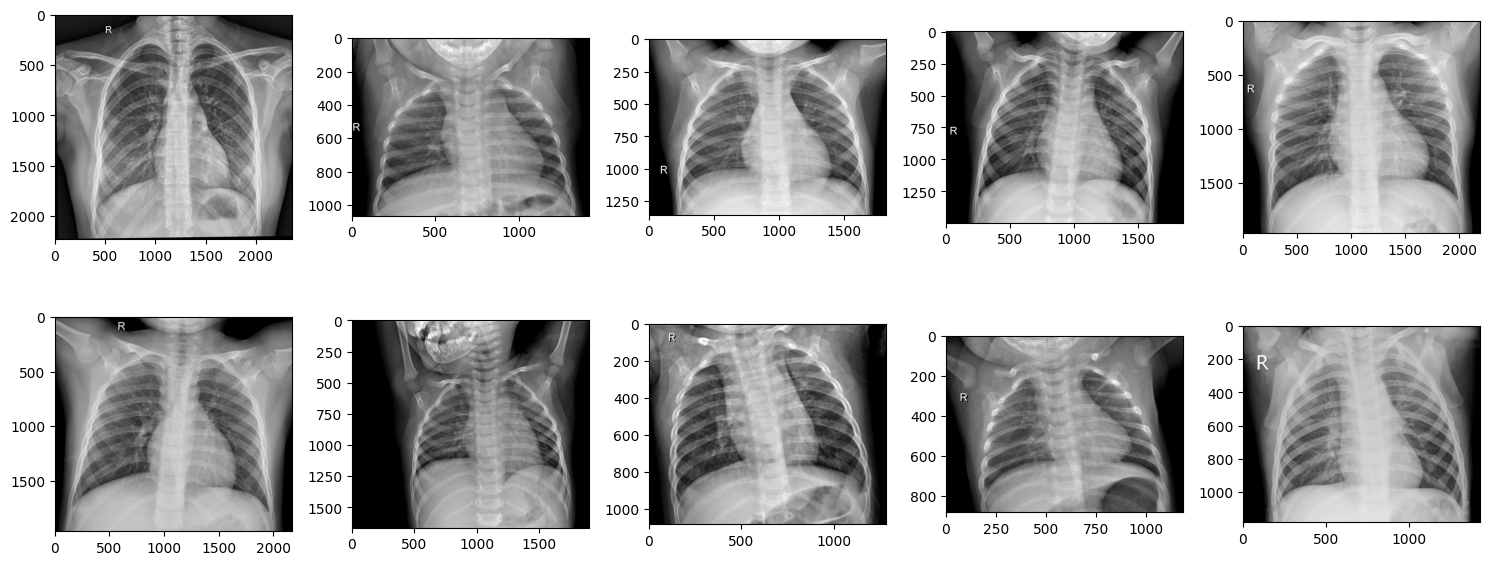

In [151]:
plt.figure(figsize = (15,15))
print ("Sample of Random Normal Pictures")
for i in range(10):
    plt.subplot(5,5,i+1)
    #Reads images from file into an array
    img = plt.imread(t_norm[i])
    plt.imshow(img, cmap = "gray")
    plt.tight_layout()
    #plt.axis('off')
    
    

<b> NORMAL PIXEL INTENSITY

Associated Normal Pixel Intensities


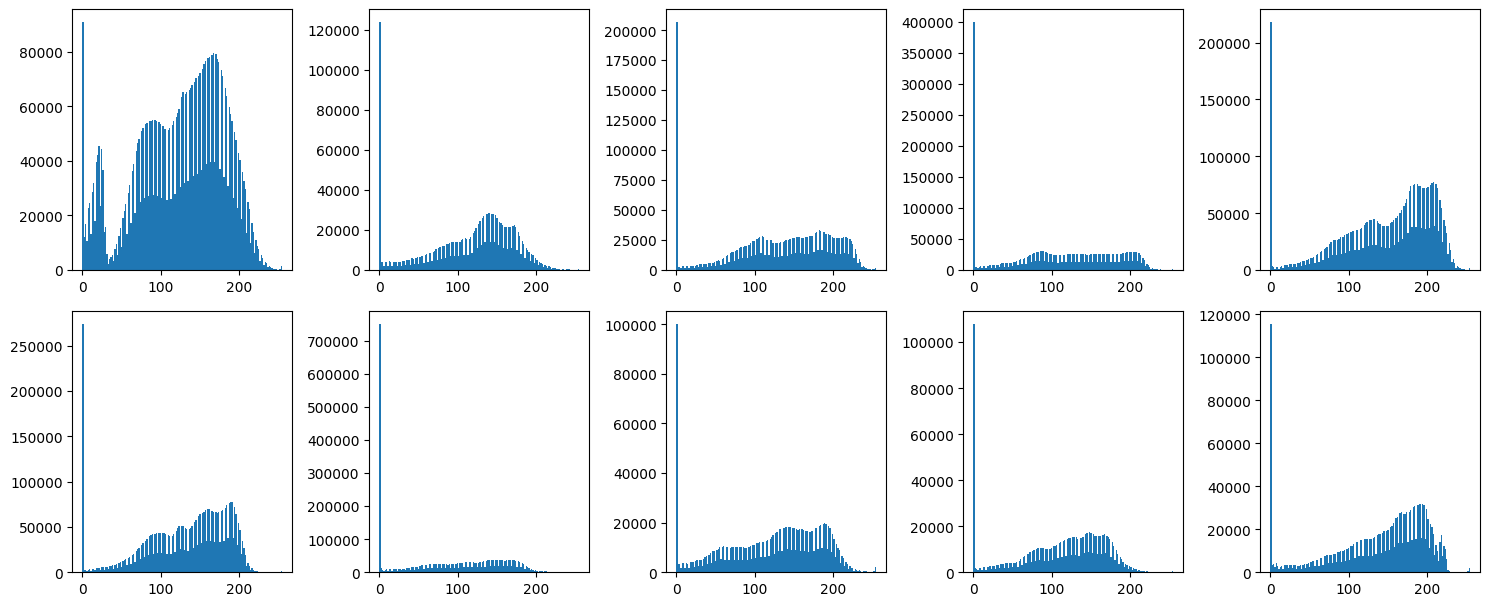

In [220]:
plt.figure(figsize = (15,15))
print ("Associated Normal Pixel Intensities")
for i in range(10):
    plt.subplot(5,5,i+1)
    img = plt.imread(t_norm[i])
    plt.hist(img.ravel(), bins=150)
    plt.tight_layout()
    #plt.axis('off')

---

<b> PNEUMONIA IMAGES

Sample of Random Pneumonia Pictures


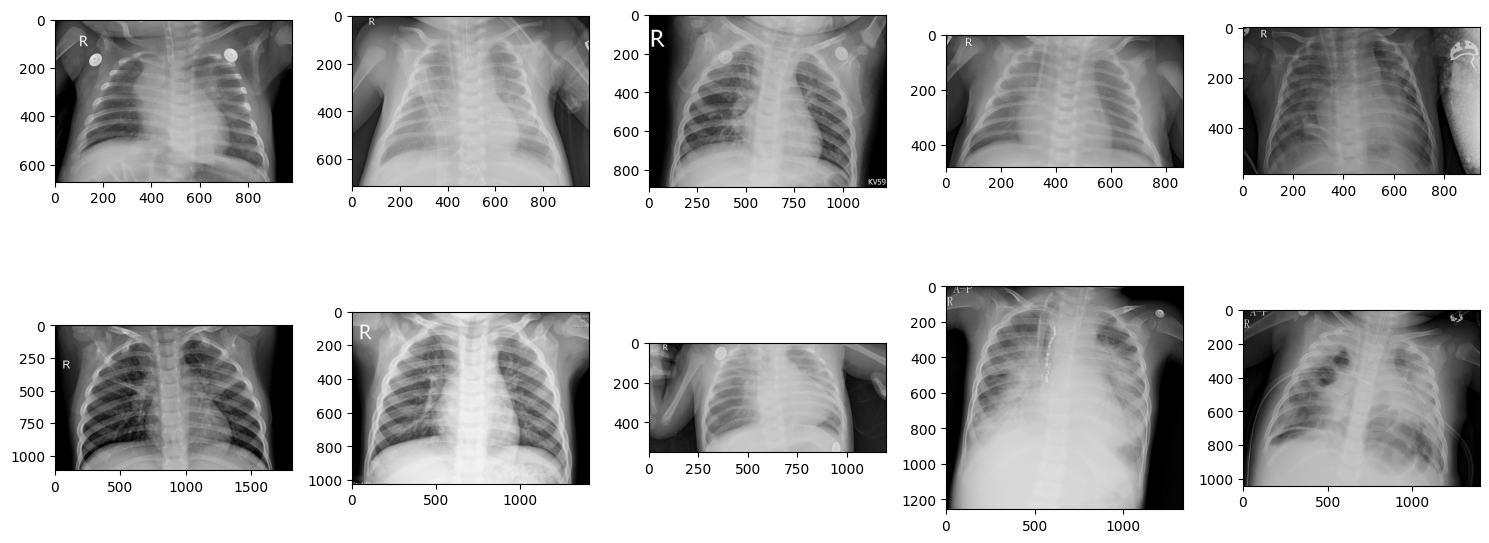

In [152]:
plt.figure(figsize = (15,15))
print ("Sample of Random Pneumonia Pictures")
for i in range(10):
    plt.subplot(5,5,i+1)
    img = plt.imread(t_pneu[i])
    plt.imshow(img, cmap = "gray")
    plt.tight_layout()
    #plt.axis('off')

Visually, both the Normal and Pneumonia pictures vary in size. Pneumonia pictures have a cloudier visual look.

<b> PNEUMONIA PIXEL IMAGES

Sample of Random Pneumonia Pictures


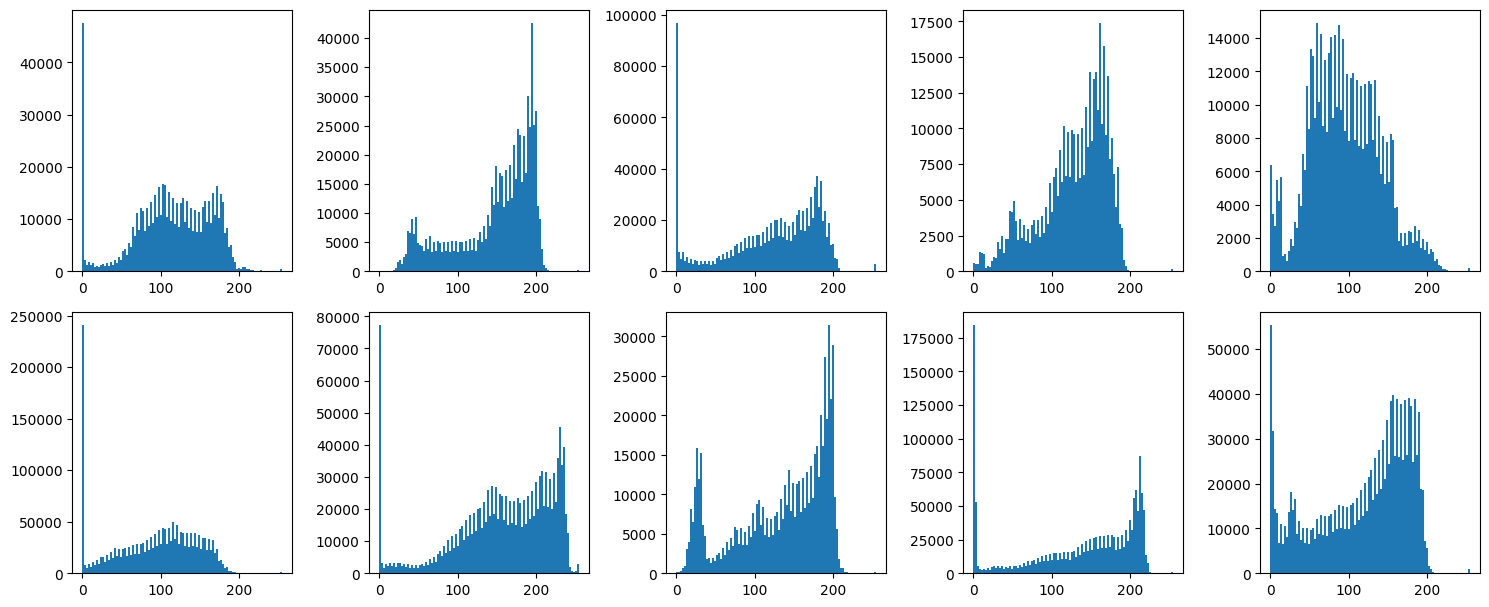

In [214]:
plt.figure(figsize = (15,15))
print ("Associated Pneumonia Pixel Intensities")
for i in range(10):
    plt.subplot(5,5,i+1)
    img = plt.imread(t_pneu[i])
    plt.hist(img.ravel(), bins=100)
    plt.tight_layout()
    #plt.axis('off')

It appears the pixel intensity is more with Pneumonia.

---

## Preprocessing Images

**Rescaling the image**  [Rescaling](https://datascience.stackexchange.com/questions/92499/rescale-parameter-in-data-augmentation#:~:text=As%20rightly%20pointed%20out%20by,evenly%20to%20the%20total%20loss)

For the intial dataset, the only preprocessing will be rescaling, creating target size and scoping the batch size. Further data augmentation will be done during the modeling.

### Image Generator

Generating batches of tensor image data with real-time data augmentation.

In [154]:
#ImageDataGenerator without pre data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

Creating directories for augmentation.  The subdirectories will be understood by the operation.

In [155]:
#Create Current Directories
train_directory= 'data/chest_xray/train'
validation_directory= 'data/chest_xray/val'
test_directory = 'data/chest_xray/test'


With the tensor image data and directory we will generate batches of augmented data.<br>


**Describe:**
- **Target Size** - Dimensions the images will be resized to
- **Batch Size** - Size of batches of data
- **Classes** - Class names 
- **Class Mode** -  "Binary" 1D Binary labels
- **Shuffle** -  Sorts data in a random matter, Default is True. 
- **Seed** - Random seed for shuffling

In [156]:
#Using a generator for the images to work with.
train_gen = train_datagen.flow_from_directory(train_directory,
                                                   target_size = (224, 224),
                                                   batch_size=64,
                                                   classes = ["NORMAL","PNEUMONIA"],
                                                   class_mode = 'binary',
                                                   seed = 42)

val_gen = val_datagen.flow_from_directory(validation_directory,
                                                      target_size = (224, 224),
                                                      batch_size = 32,
                                                      classes = ["NORMAL","PNEUMONIA"],
                                                      class_mode = 'binary',
                                                      seed = 42)
test_gen = test_datagen.flow_from_directory(test_directory,
                                                      target_size = (224, 224),
                                                      batch_size = 624,
                                                      classes = ["NORMAL","PNEUMONIA"],
                                                      class_mode = 'binary',
                                                      seed = 42,
                                                      shuffle= False)                                                      

Found 4325 images belonging to 2 classes.
Found 907 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [157]:
#Checking the class label and index match
print(train_gen.class_indices)
print(val_gen.class_indices)

{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}


Iterating through the generated images.
X and y are the images and labels respectively. It is a sample equal to the batch size above.

In [158]:
X_train, y_train = next(train_gen)
X_val, y_val = next(val_gen)
X_test, y_test = next(test_gen)

print("X_train:",len(X_train),"y_train:",len(y_train))
print("X_val:",len(X_val),"y_val:",len(y_val))
print("X_test:",len(X_test),"y_test:",len(y_test))

X_train: 64 y_train: 64
X_val: 32 y_val: 32
X_test: 624 y_test: 624


# Modeling


### Custom Functions for Model Evaluation


[Visualization Metrics,A.Jang 2023](https://www.kaggle.com/code/amyjang/tensorflow-pneumonia-classification-on-x-rays#8.-Visualizing-model-performance)

In [159]:
#Create a new directory for saved files
directory = "saved_files"
save_path = os.path.join(cur_dir,directory)
try: 
    os.mkdir(save_path) 
except OSError as error: 
    print(error)

[Errno 17] File exists: '/Users/deztanyjackson/Documents/0_Flatiron/Phase_4/Project_4/Image_Classification_P4/saved_files'


In [160]:
#Pickle saving
def save_file(name,file):
    """ Saving file to a specific directory using pickle"""
    saved_name = os.path.join(save_path,name)
    with open(saved_name, 'wb') as f:
        pickle.dump(file, f)


In [161]:
#loading file
def load_file(name):
    """ Loading file from a specific directory using pickle"""
    saved_name = os.path.join(save_path,name)
    with open(saved_name, 'rb') as f:
        file = pickle.load(f)
    return file

In [162]:
def eval_metrics(history):
    """ Plots Train and Validation metrics["acc","loss","recall","precision"]
    from a model's evaluation results."""
    
    fig, ax = plt.subplots(1,4, figsize = (25,5))
    fig.suptitle('Model Metrics Results')
    
    metrics = ["loss","recall","acc","precision"]   
    
    for i, metric in enumerate(metrics):
    
        ax[i].plot(history.history[metric])
        ax[i].plot(history.history["val_" + metric])
        ax[i].set_title('Model {}'.format(metric))
        ax[i].set_ylabel(metric)
        ax[i].set_xlabel("Epochs")
        ax[i].legend(['train', 'val'])

        

[Predictor Algorithm with Shuffle,by Jakob, 2021](https://stackoverflow.com/questions/45413712/keras-get-true-labels-y-test-from-imagedatagenerator-or-predict-generator/67282636#67282636)

In [163]:
def predict_results(model,generator):
    """Generates prediction results and true labels from a specific model and specific data set. 
    This formula works well for shuffled generated data."""
    
    # Create lists for storing the predictions and labels
    predictions = []
    labels = []

    # Get the total number of labels in generator 
    # (i.e. the length of the dataset where the generator generates batches from)
    n = len(generator.labels)

    # Loop over the generator
    for data, label in generator:
        # Make predictions on data using the model. Store the results.
        predictions.extend(model.predict(data).flatten())

        # Store corresponding labels
        labels.extend(label)

        # We have to break out from the generator when we've processed 
        # the entire once (otherwise we would end up with duplicates). 
        if (len(label) < generator.batch_size) and (len(predictions) == n):
            break
        return labels, predictions #y_true, y_hat_train/y_pred

In [164]:
def conf_matrix(y_true,y_pred, norm_bool):
    """Prints confusion matrix for the Normal and Pneumonia true and predicted values. """
    y_pred = np.round(y_pred,0) #Rounding to the nearest 0 or 1, assumes threshold is >.5 for
    cmatrix= cm(y_true, y_pred, normalize=norm_bool)# Allows normalized matrix
    matrix_disp= ConfusionMatrixDisplay(cmatrix, display_labels= ["NORMAL", "PNUEMONIA"])
    matrix_disp.plot()

    plt.xlabel('Predictions')
    plt.ylabel('Actual')
    plt.title('Model Confusion Matrix')
    plt.show()
    

In [165]:
def eval_report(y_true, y_pred,gen,history):
    """ Displaying the classification report and loss from the model results"""
    y_pred = np.round(y_pred,0) # Rounding to the nearest 0 or 1
    #Display Precision, Recall, F1 and Accuracy
    print(classification_report(y_true, y_pred))
    print('\n')
    
    #Display Model Metrics
    loss, _,_,_ = history.model.evaluate(gen)
   
    print(f'Loss: {np.round(loss,4)}')
   


In [166]:
# set up the class weights using y_train
def calc_weight(labels):
    """ Setting the weights and pairing it with the classes for the class weight paramters in model.fit. 
    Labels can also be thought of as y_train"""
    classes = [0,1]
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=labels)
    class_weights = dict(zip(classes, weights))
    return class_weights

### The following is the outline of each model iteration:

- Sequence <br>
- Compile <br>
- Summary <br>
- Fit <br>
- Predict <br>
- Conf_matrix <br>
- Eval report <br>
- Model Evaluation <br>

Each iteration will have slight changes for improvement.  They will be described more at the
General descriptions of specific iterations.

### The main metrics focused on are:
- **Recall, F1 Score, Loss (Primary)** <br>
- **and Accuracy (Secondary)**<br>

Because the goal is to minimized False Negatives of Pneumonia (predicting no Pneumonia, while there is). 
The True Positives will be looked at secondary.

There are a total of 10* model iterations with a Final Model. The model iterations are trained on the training data and tested on validation data. Both the training and validation data metrics will be displayed.

The Final Model will be chosen based on the main metrics. This final model will be used with the test data. 


# Baseline Modeling (1)

Description of the main model hyperparameters and data parameters:

- **Model**
    - layers: 3 Conv2D each w/ MaxPooling2D, 2 Dense output layers
    - filters: 32,64,96 for Conv2D, 64,1 Dense layer
    - activation: Relu for all except Sigmoid for output layer
- **Model Compile**
    - loss: binary_crossentropy
    - optimizer:adam
    - learning rate: .001 (Default)
    - metrics: Accuracy,Recall,Precision
- **Fit**
    - data: train_gen, val_gen
    - train batchsize: 64
    - epochs: 10
- **Additional Comments** 
    - Conv2D model is best for images
    - MaxPooling 2D is a downsampling strategy CNNs



In [167]:
# Baseline Model Stack
baseline = models.Sequential([
Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
       padding = 'same', input_shape=(224,224,3)),
MaxPooling2D(pool_size=(2, 2), strides=2), 
    
Conv2D(filters=64, kernel_size=(3, 3), activation='relu', 
       padding = 'same'),
MaxPooling2D(pool_size=(2, 2), strides=2),
    
Conv2D(filters=96, kernel_size=(3, 3), activation='relu', 
       padding = 'same'),
MaxPooling2D(pool_size=(2, 2), strides=2),
Flatten(),
Dense(units=64, activation='relu'),    
Dense(units=1, activation='sigmoid'),
])

#Compile Model
baseline.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=["acc","Recall","Precision"])

The model summary provides a description of the sequential Layers, Output Shapes and Learning Parameters.

In [168]:
#Display model summary (layers and)
baseline.summary()

Model: "sequential_94"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_393 (Conv2D)         (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_393 (MaxPooli  (None, 112, 112, 32)     0         
 ng2D)                                                           
                                                                 
 conv2d_394 (Conv2D)         (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_394 (MaxPooli  (None, 56, 56, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_395 (Conv2D)         (None, 56, 56, 96)        55392     
                                                                 
 max_pooling2d_395 (MaxPooli  (None, 28, 28, 96)     

Returning a model object that contains model evaluation metrics, and hyperparameter attributes

In [192]:
#Fiting the data
history = baseline.fit(train_gen,
                       epochs=10,
                       verbose = 2,
                       validation_data=val_gen)

Epoch 1/10


2023-03-28 09:58:34.664618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


68/68 - 29s - loss: 0.2125 - acc: 0.9064 - recall: 0.9243 - precision: 0.9482 - val_loss: 0.1381 - val_acc: 0.9449 - val_recall: 0.9346 - val_precision: 0.9906 - 29s/epoch - 423ms/step
Epoch 2/10
68/68 - 26s - loss: 0.1474 - acc: 0.9454 - recall: 0.9639 - precision: 0.9627 - val_loss: 0.0746 - val_acc: 0.9768 - val_recall: 0.9866 - val_precision: 0.9822 - 26s/epoch - 384ms/step
Epoch 3/10
68/68 - 25s - loss: 0.0860 - acc: 0.9686 - recall: 0.9798 - precision: 0.9779 - val_loss: 0.0677 - val_acc: 0.9779 - val_recall: 0.9777 - val_precision: 0.9925 - 25s/epoch - 374ms/step
Epoch 4/10
68/68 - 26s - loss: 0.0641 - acc: 0.9748 - recall: 0.9822 - precision: 0.9838 - val_loss: 0.0705 - val_acc: 0.9735 - val_recall: 0.9941 - val_precision: 0.9710 - 26s/epoch - 377ms/step
Epoch 5/10
68/68 - 25s - loss: 0.0504 - acc: 0.9822 - recall: 0.9863 - precision: 0.9897 - val_loss: 0.0497 - val_acc: 0.9802 - val_recall: 0.9896 - val_precision: 0.9838 - 25s/epoch - 375ms/step
Epoch 6/10
68/68 - 26s - loss: 

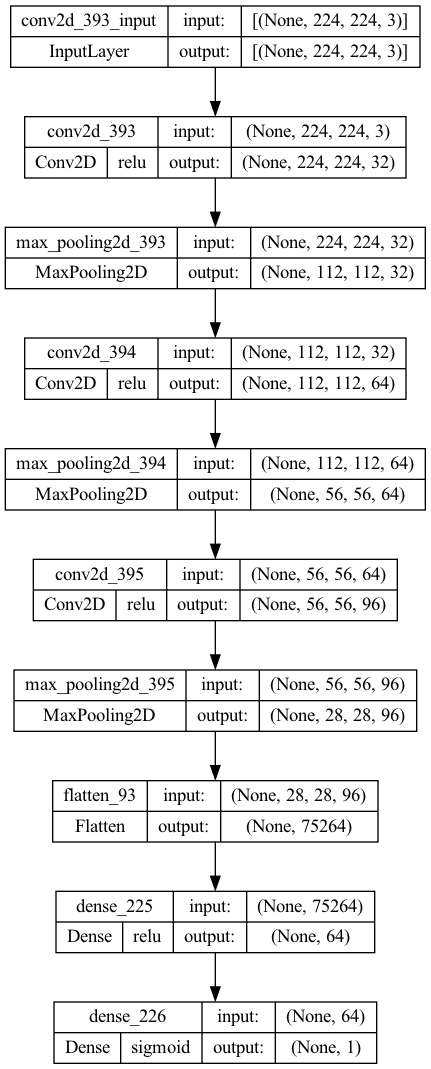

In [193]:
# Plot of model's shape visually
plot_model(baseline, show_shapes=True, show_layer_names=True, show_layer_activations=True)

<b> Baseline Metrics

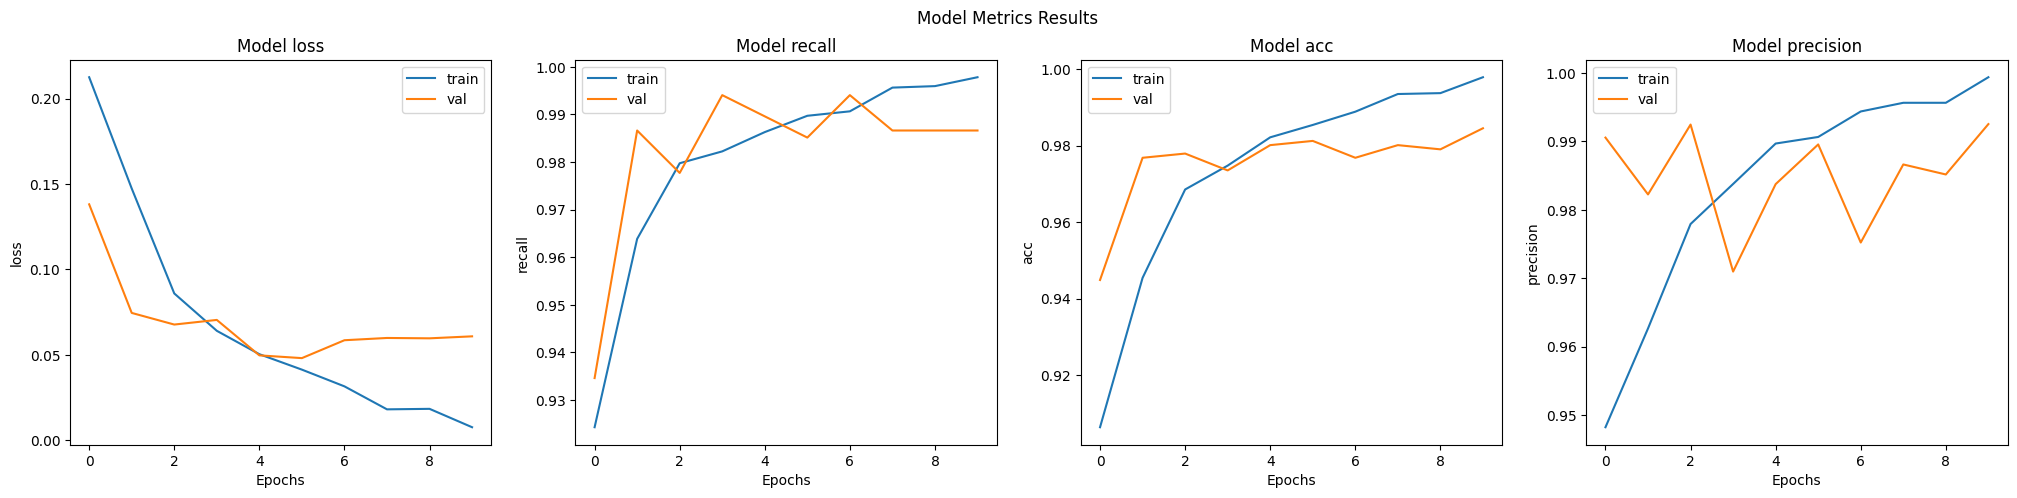

In [194]:
#Plotting chosen Train and Validation Metrics
eval_metrics(history)

In [195]:
#Returns Train and Validation labels and predictions
train_labels, train_predictions = predict_results(baseline,train_gen)
val_labels, val_predictions = predict_results(baseline,val_gen)

2/2 [==============================] - 0s 47ms/step


2023-03-28 10:06:51.630409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 13ms/step


Training Confusion Matrices:



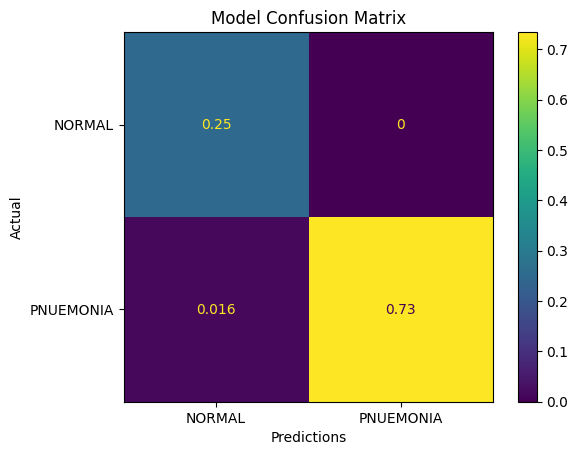

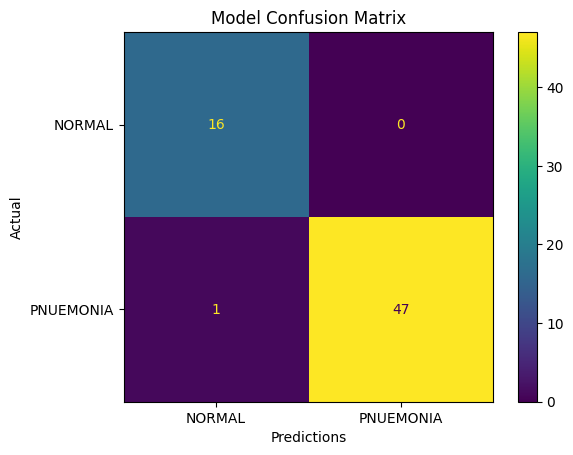

Validation Confusion Matrices:



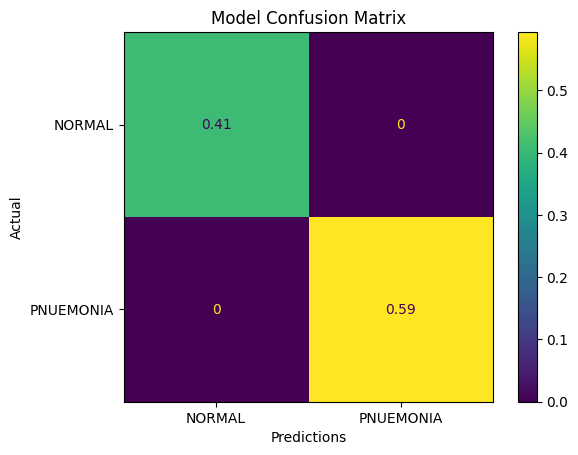

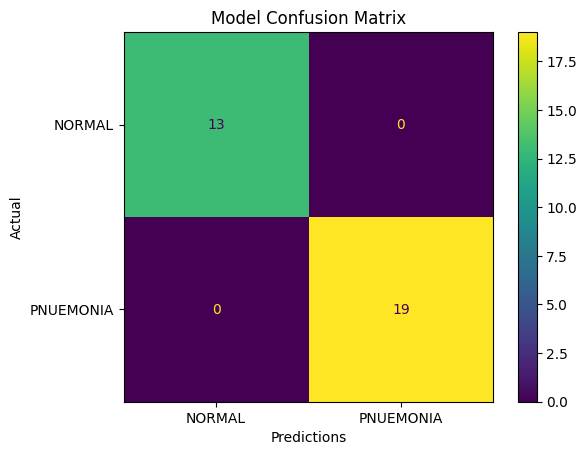

In [196]:
#Printing regular and normalized Confusion Matrices
print("Training Confusion Matrices:\n")
conf_matrix(train_labels,train_predictions, "all")
conf_matrix(train_labels,train_predictions, None)
print("Validation Confusion Matrices:\n")
conf_matrix(val_labels, val_predictions, "all")
conf_matrix(val_labels, val_predictions, None)

In [197]:
#Training Classification Report
print("Training Classificaiton Report:\n")
eval_report(train_labels,train_predictions,train_gen,history)

Training Classificaiton Report:

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97        16
         1.0       1.00      0.98      0.99        48

    accuracy                           0.98        64
   macro avg       0.97      0.99      0.98        64
weighted avg       0.99      0.98      0.98        64



68/68 [==============================] - 21s 297ms/step - loss: 0.0070 - acc: 0.9979 - recall: 0.9975 - precision: 0.9997
Loss: 0.007


In [221]:
#Validation Classification Report
print("Validation Classificaiton Report:\n")
eval_report(val_labels,val_predictions,val_gen,history)

Validation Classificaiton Report:

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         6
         1.0       1.00      1.00      1.00        26

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



29/29 [==============================] - 5s 161ms/step - loss: 0.0608 - acc: 0.9846 - recall: 0.9866 - precision: 0.9925
Loss: 0.0608


### Baseline (1) Model Evaluation

- Model Plots: All of the metrics training and validation data show the model is overfit.
- Condusion Matrix: With the current batch size and imbalanced data, the model predicted everything as true, even on the training set. This led to no False Negatives, but many False Positives.
- Report: The precision and f1 score increase in the validation model. This is not so significant, because mostly everthing was chosen as Pneumonia. The loss in the validation model is drastically different from the training model.
- The next model should make improvements to help with the imbalance and improve overfitting.

---

# Baseline Model (2) with Class Weights 

Change Description: 
- Adding class weights to see it helps with class imbalance.

Description of the model hyperparameters and data parameters:


- **Model**
    - layers: 3 Conv2D each w/ MaxPooling2D, 2 Dense output layers
    - filters: 32,64,96 for Conv2D, 64,1 Dense layer
    - activation: Relu for all except Sigmoid for output layer
- **Model Compile**
    - loss: binary_crossentropy
    - optimizer:adam
    - learning rate: .001 (Default)
    - metrics: Accuracy,Recall,Precision
- **Fit**
    - data: train_gen, val_gen
    - train batchsize: 64
    - epochs: 10
    - **Added class weights**: {0: 1.28, 1: 0.8205128205128205}
- **Additional Comments** 
    - Conv2D model is best for images
    - MaxPooling 2D is a downsampling strategy CNNs

In [ ]:
# Baseline Model Stack
baseline2 = models.Sequential([
Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
       padding = 'same', input_shape=(224,224,3)),
MaxPooling2D(pool_size=(2, 2), strides=2), 
    
Conv2D(filters=64, kernel_size=(3, 3), activation='relu', 
       padding = 'same'),
MaxPooling2D(pool_size=(2, 2), strides=2),
    
Conv2D(filters=96, kernel_size=(3, 3), activation='relu', 
       padding = 'same'),
MaxPooling2D(pool_size=(2, 2), strides=2),
Flatten(),
Dense(units=64, activation='relu'),    
Dense(units=1, activation='sigmoid'),
])

#Compile Model
baseline2.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=["acc","Recall","Precision"])

Calculating class weights help to balance the dataset by weighting respecively.

In [ ]:
#Calculating class weights for imbalance
class_weights = calc_weight(y_train)
class_weights

In [ ]:
#Fitting the data on the baseline model with class weight
history2 = baseline2.fit(train_gen,
                       epochs=10,
                       verbose = 2,
                       class_weight=class_weights,
                       validation_data=val_gen)

In [ ]:
#Baseline2 Summary
baseline2.summary()

Basline Evaluation Metrics w/ Class Weights :



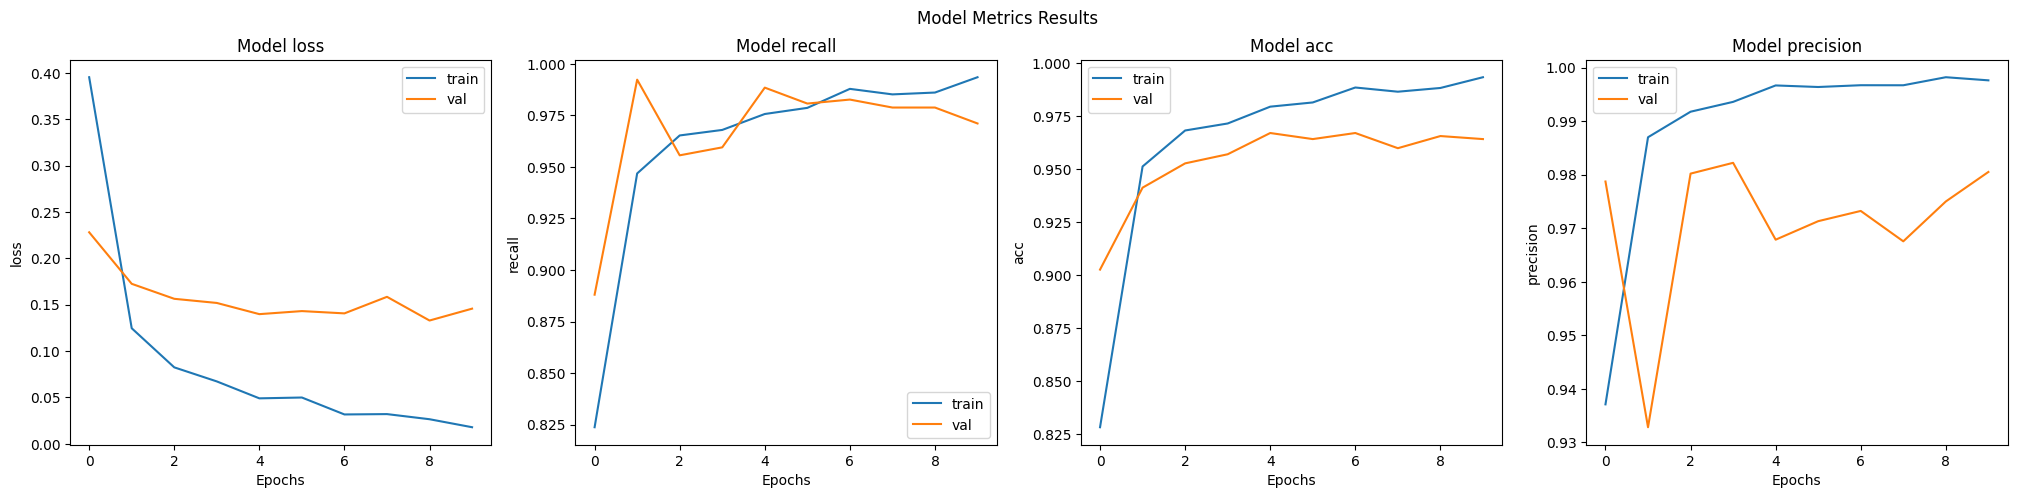

In [199]:
print("Basline Evaluation Metrics w/ Class Weights :\n")
eval_metrics(history2)

In [200]:
#Returns Train and Validation labels and predictions
train_labels, train_predictions = predict_results(baseline2,train_gen)
val_labels, val_predictions = predict_results(baseline2,val_gen)

1/1 [==============================] - 0s 35ms/step


Training Confusion Matrices:



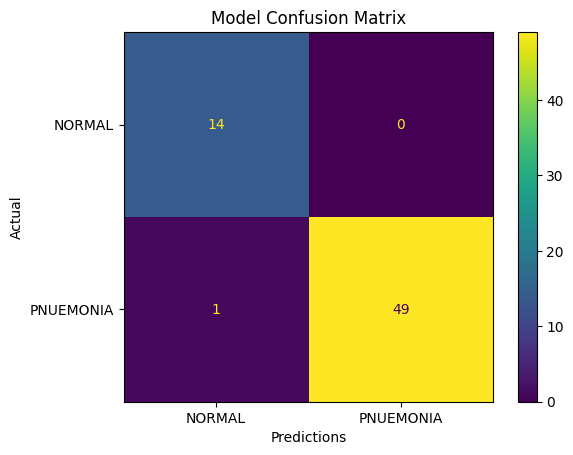

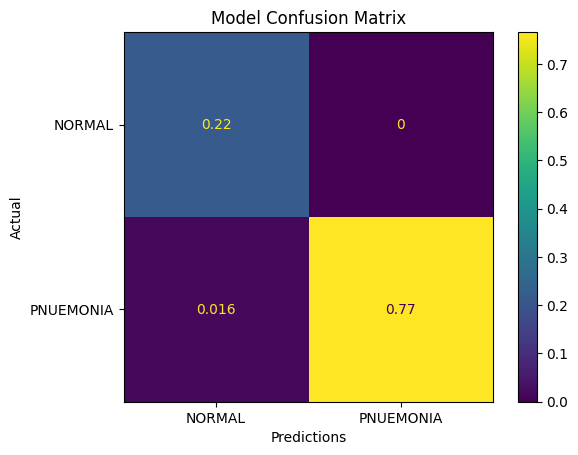

Validation Confusion Matrices:



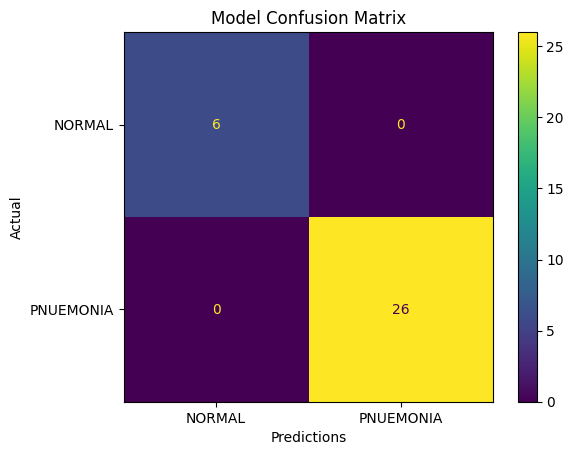

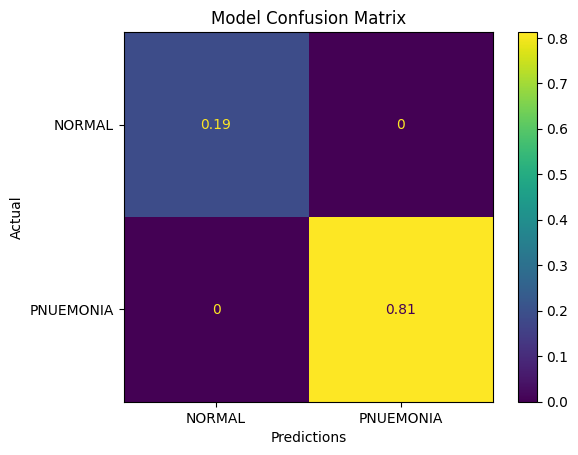

In [201]:
#Printing regular and normalized Confusion Matrices
print("Training Confusion Matrices:\n")
conf_matrix(train_labels,train_predictions, None)
conf_matrix(train_labels,train_predictions, "all")
print("Validation Confusion Matrices:\n")
conf_matrix(val_labels, val_predictions, None)
conf_matrix(val_labels, val_predictions, "all")

In [202]:
#Training Classification Report
print("Training Classificaiton Report:\n")
eval_report(train_labels,train_predictions,train_gen,history2)

Training Classificaiton Report:

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.97        14
         1.0       1.00      0.98      0.99        50

    accuracy                           0.98        64
   macro avg       0.97      0.99      0.98        64
weighted avg       0.99      0.98      0.98        64



68/68 [==============================] - 20s 293ms/step - loss: 0.0393 - acc: 0.9880 - recall: 0.9869 - precision: 0.9969
Loss: 0.0393


In [222]:
#Training Classification Report
print("Validation Classificaiton Report:\n")
eval_report(val_labels,val_predictions,val_gen,history2)

Validation Classificaiton Report:

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         6
         1.0       1.00      1.00      1.00        26

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



29/29 [==============================] - 5s 170ms/step - loss: 0.0109 - acc: 0.9945 - recall: 0.9926 - precision: 1.0000
Loss: 0.0109


### Baseline (2) Model Evaluation

- Model Plots: Drastic improvement with the class weight, but still includes slight variation with recall and precision.  The metrics seem to be diverging as the epochs increase. The concludes that the model is still slightly overfitting.
- Confusion Matrix: There is one FN with the validation set and no False Positives. 
- Report: The loss is a lot less with the validation set.
- Ths model wasn't bad. The validation and training set are getting comparable results. The next model should make improvements to help with the complexity and overfitting.

---

# Model Iteration 3

Change Description: 
- Increase Epochs, Adding EarlyStop and Dropout between Dense layers

Description of the model hyperparameters and data parameters:


- **Model**
    - layers: 3 Conv2D each w/ MaxPooling2D, 2 Dense output layers
    - filters: 32,64,96 for Conv2D, 64,1 Dense layer
    - activation: Relu for all except Sigmoid for output layer
    - **dropout**: .3
- **Model Compile**
    - loss: binary_crossentropy
    - optimizer:adam
    - learning rate: .001 (Default)
    - metrics: Accuracy,Recall,Precision
- **Fit**
    - data: train_gen, val_gen
    - train batchsize: 64
    - **epochs**: 30
    - **early stopping** : True
    - class weights: {0: 1.28, 1: 0.8205128205128205}
- **Additional Comments** 
    - Conv2D model is best for images
    - MaxPooling 2D is a downsampling strategy CNNs

In [ ]:
#Model 3 Sequential Layers
model_3= models.Sequential([
Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
       padding = 'same', input_shape=(224,224,3)),
MaxPooling2D(pool_size=(2, 2), strides=2), 
    
Conv2D(filters=64, kernel_size=(3, 3), activation='relu', 
       padding = 'same'),
MaxPooling2D(pool_size=(2, 2), strides=2),
    
Conv2D(filters=96, kernel_size=(3, 3), activation='relu', 
       padding = 'same'),
MaxPooling2D(pool_size=(2, 2), strides=2),
Flatten(),
Dense(units=64, activation='relu'), 
Dropout(0.3),  
Dense(units=1, activation='sigmoid'),
])
#Compile model
model_3.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=["acc","Recall","Precision"]
                 )

Early stopping allows the execution of the model fitting to stop when the model has stopped improving.

In [ ]:
#Adding early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [ ]:
history3 = model_3.fit(train_gen,
                       epochs=30,
                       verbose = 2,
                       class_weight=class_weights,
                       validation_data=val_gen,
                      callbacks = es)

In [ ]:
model_3.summary()

In [ ]:
print("Model 3: Dropout, EarlyStopping and 30 Epochs :\n")
eval_metrics(history3)

In [ ]:
train_labels, train_predictions = predict_results(model_3,train_gen)
val_labels, val_predictions = predict_results(model_3,val_gen)

In [ ]:
#Printing regular and normalized Confusion Matrices
print("Training Confusion Matrices:\n")
conf_matrix(train_labels,train_predictions, None)
conf_matrix(train_labels,train_predictions, "all")
print("Validation Confusion Matrices:\n")
conf_matrix(val_labels, val_predictions, None)
conf_matrix(val_labels, val_predictions, "all")

In [223]:
#Training Classification Report
print("Training Classificaiton Report:\n")
eval_report(train_labels,train_predictions,train_gen,history3)

Training Classificaiton Report:

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.97        14
         1.0       1.00      0.98      0.99        50

    accuracy                           0.98        64
   macro avg       0.97      0.99      0.98        64
weighted avg       0.99      0.98      0.98        64



68/68 [==============================] - 22s 325ms/step - loss: 0.0364 - acc: 0.9894 - recall: 0.9888 - precision: 0.9969
Loss: 0.0364


In [224]:
#Training Classification Report
print("Validation Classificaiton Report:\n")
eval_report(val_labels,val_predictions,val_gen,history3)

Validation Classificaiton Report:

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         6
         1.0       1.00      1.00      1.00        26

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



29/29 [==============================] - 5s 168ms/step - loss: 0.0129 - acc: 0.9945 - recall: 0.9926 - precision: 1.0000
Loss: 0.0129


### Model 3 Evaluation

- Model Plots: The metrics seem to be diverging as the epochs increase. The concludes that the model is still slightly overfitting. 
- Confusion Matrix: There is one FN and one FP. This is slightly worse than the previous model.
- Report: The loss is a lot less with the validation set.
- Ths model wasn't bad. The validation and training set are getting comparable results. The next model should make improvements to help with the complexity and overfitting.

---

# Model Iterations 4-7 
**These models will use  Keras wrappers amd GridsearchCV to optimize various hyperparameters in the models. The best parameters will be applied along to the model.**

---

# Model 4 

Using gridsearch and keras wrappers to do some hyperparameter optimization
- **batch_size = [32,64,96,128]**
- **epochs = [30,45,60,90]**

Description of the model hyperparameters and data parameters:


- **Model**
    - layers: 3 Conv2D each w/ MaxPooling2D, 2 Dense output layers
    - filters: 32,64,96 for Conv2D, 64,1 Dense layer
    - activation: Relu for all except Sigmoid for output layer
    - dropout: .3
- **Model Compile**
    - loss: binary_crossentropy
    - optimizer:adam
    - learning rate: .001 (Default)
    - metrics: Accuracy,Recall,Precision
- **Fit**
    - data: train_gen, val_gen
    - train batchsize: 64
    - **epochs:** 45
    - early stopping : True
    - class weights: {0: 1.28, 1: 0.8205128205128205}
- **Additional Comments** 
    - Conv2D model is best for images
    - MaxPooling 2D is a downsampling strategy CNNs

In [ ]:
# Creating a function to supply to the Keras wrapper
def buildModel():

    model= models.Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
           padding = 'same', input_shape=(224,224,3)),
    MaxPooling2D(pool_size=(2, 2), strides=2), 

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', 
           padding = 'same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Conv2D(filters=96, kernel_size=(3, 3), activation='relu', 
           padding = 'same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
        
    Flatten(),
    Dense(units=64, activation='relu'), 
    Dropout(0.3),  
    Dense(units=1, activation='sigmoid'),])

    model.compile(loss='binary_crossentropy',
                optimizer="adam",
                metrics=["acc","Recall","Precision"]
                 )
    return model

Choosing hyperparameters range to optimize. Being mindful of hardware and software resources.

In [ ]:
#Choosing Paramers for Optimization
batch_size = [32,64,96,128]
epochs = [30,45,60,90]
parameters = dict(batch_size=batch_size, epochs=epochs )


In [ ]:
#Early Stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

[GridSearchCV with CNN, Aaryn Dhore, 2020](https://www.kaggle.com/code/aaryandhore/neural-network-gridsearchcv-explanations/notebook)<br>
[GridSearch for Deep Learning, J. Brownlee, 2022](https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/)

KerasClassifier creates a classifier from the Model Sequence build model to use as an estimator. The created parameters will be used as the parameters in the Gridsearch to help optimize.

In [ ]:
#Creating a wrapped classifier
classifier = KerasClassifier(build_fn=buildModel, class_weight = class_weights)

#Gridsearch Creating 
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           refit = "Acc",
                           scoring = "accuracy",
                           cv = 3,return_train_score=True)
#Fitting Gridsearch
gs = grid_search.fit(X_train, y_train, verbose = 0)

In [ ]:
#Printing best score and parameters
print("Best: %f using %s" % (gs.best_score_, gs.best_params_))

### Plotting Model 4 with best parameters

In [ ]:
# Model 4
model_4= models.Sequential([
Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
       padding = 'same', input_shape=(224,224,3)),
MaxPooling2D(pool_size=(2, 2), strides=2), 
    
Conv2D(filters=64, kernel_size=(3, 3), activation='relu', 
       padding = 'same'),
MaxPooling2D(pool_size=(2, 2), strides=2),
    
Conv2D(filters=96, kernel_size=(3, 3), activation='relu', 
       padding = 'same'),
MaxPooling2D(pool_size=(2, 2), strides=2),
    
Flatten(),  
Dense(units=64, activation='relu'),
Dropout(0.3),    
Dense(units=1, activation='sigmoid'),
])

model_4.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=["acc","Recall","Precision"]
                 )

In [ ]:
#Fitting model with best parameters
history4 = model_4.fit(train_gen,
                       epochs=45,
                       verbose = 2,
                       class_weight=class_weights,
                       validation_data=val_gen,
                      callbacks = es) #stopping early because of time resources

In [ ]:
#Model Summary
model_4.summary()

In [ ]:
print("Basline Evaluation Metrics Best Metrics :\n")
eval_metrics(history4)

In [ ]:
train_labels, train_predictions = predict_results(model_4,train_gen)
val_labels, val_predictions = predict_results(model_4,val_gen)

In [ ]:
#Printing regular and normalized Confusion Matrices
print("Training Confusion Matrices:\n")
conf_matrix(train_labels,train_predictions, None)
conf_matrix(train_labels,train_predictions, "all")
print("Validation Confusion Matrices:\n")
conf_matrix(val_labels, val_predictions, None)
conf_matrix(val_labels, val_predictions, "all")

In [ ]:
#Training Classification Report
print("Training Classificaiton Report:\n")
eval_report(train_labels,train_predictions,train_gen,history4)

In [ ]:
#Training Classification Report
print("Validation Classificaiton Report:\n")
eval_report(val_labels,val_predictions,val_gen,history4)

In [ ]:
### Model 4 Evaluation

- Model Plots: The metrics seem to be diverging and varying as the epochs increase.  The concludes that the model is still slightly overfitting. 
- Confusion Matrix: There is one FP and no FN.
- Report: The loss is a lot less with the validation set.
- Ths model wasn't bad. The validation's loss increased. The recall and f1score decreased from the previous model metrics.


---

# Model 5 

Using gridsearch and keras wrappers to do some hyperparameter optimization
- epochs = [45,65]
- optimizer = ['adam', "SGD"]
- dropout_rate = [.3,.5] 
- Will add more layers for more complexity.

Description of the model hyperparameters and data parameters:

- **Model***
    - **layers: 6 Conv2D each w/ MaxPooling2D, 3 Dense output layers
    - filters: 32,64,96 for Conv2D, 64,1 Dense layer
    - activation: Relu for all except Sigmoid for output layer
    - **dropout:** .3 between the dense output layers
- **Model Compile**
    - loss: binary_crossentropy
    - **optimizer:**adam
    - learning rate: .001 (Default)
    - metrics: Accuracy,Recall,Precision
- **Fit**
    - data: train_gen, val_gen
    - train batchsize: 64
    - **epochs:** 65
    - early stopping : True
    - class weights: {0: 1.28, 1: 0.8205128205128205}
- **Additional Comments** 
    - Conv2D model is best for images
    - MaxPooling 2D is a downsampling strategy CNNs

In [ ]:
#Build model for classifier with parameters in signature
def buildModel(dropout_rate, optimizer = "adam"):

    model= models.Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
           padding = 'same', input_shape=(224,224,3)),
    MaxPooling2D(pool_size=(2, 2), strides=2), 

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', 
           padding = 'same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Conv2D(filters=96, kernel_size=(3, 3), activation='relu', 
           padding = 'same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Conv2D(filters=96, kernel_size=(3, 3), activation='relu', 
           padding = 'same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', 
           padding = 'same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', 
           padding = 'same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Flatten(),

    Dense(units=128, activation='relu',), 
    Dropout(dropout_rate),
    Dense(units=64, activation='relu'),
    Dropout(dropout_rate),    
    Dense(units=1, activation='sigmoid'),
    ])

    model.compile(loss='binary_crossentropy',
                    optimizer= optimizer,
                    metrics=["acc","Recall","Precision"]
                     )
    return model

In [ ]:
#Hyperparameters for GridsearchCV
epochs = [45,65]
optimizer = ['adam', "SGD"]
dropout_rate = [.3,.5] 

#Creating a dictionary to use as parameters
parameters_2 = dict(optimizer=optimizer, dropout_rate=dropout_rate,  epochs=epochs )
parameters_2

In [ ]:
#Creating a wrapped classifier
classifier = KerasClassifier(build_fn=buildModel, batch_size = 64, class_weight = class_weights)

#Gridsearch Creation
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters_2,
                           refit = "Acc",
                           scoring = "accuracy",
                           cv = 3,return_train_score=True)
#Gridsearch Fitting
gs_2 = grid_search.fit(X_train, y_train, verbose = 1)

In [ ]:
print("Best: %f using %s" % (gs_2.best_score_, gs_2.best_params_))

# Model 5 with Best Parameters


In [ ]:
model_5= models.Sequential([
Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
           padding = 'same', input_shape=(224,224,3)),
MaxPooling2D(pool_size=(2, 2), strides=2), 

Conv2D(filters=64, kernel_size=(3, 3), activation='relu', 
           padding = 'same'),
MaxPooling2D(pool_size=(2, 2), strides=2),

Conv2D(filters=96, kernel_size=(3, 3), activation='relu', 
           padding = 'same'),
MaxPooling2D(pool_size=(2, 2), strides=2),

Conv2D(filters=96, kernel_size=(3, 3), activation='relu', 
           padding = 'same'),
MaxPooling2D(pool_size=(2, 2), strides=2),

Conv2D(filters=128, kernel_size=(3, 3), activation='relu', 
           padding = 'same'),
MaxPooling2D(pool_size=(2, 2), strides=2),

Conv2D(filters=128, kernel_size=(3, 3), activation='relu', 
           padding = 'same'),
MaxPooling2D(pool_size=(2, 2), strides=2),

Flatten(),

Dense(units=128, activation='relu',), 
Dropout(.3),
Dense(units=64, activation='relu'),
Dropout(.3),    
Dense(units=1, activation='sigmoid'),
    ])

model_5.compile(loss='binary_crossentropy',
                    optimizer= "adam",
                    metrics=["acc","Recall","Precision"]
                     )

In [ ]:
#Model 5 Summary
model_5.summary()

In [ ]:
#Modeling with best parameters
history5 = model_5.fit(train_gen,
                       epochs=65,
                       verbose = 2,
                       class_weight=class_weights,
                       validation_data=val_gen,
                      callbacks = es) #stopping early because of time resources

In [ ]:
print("Model 5 with updated hyperparamters :\n")
eval_metrics(history5)

- Model Plots: The metrics seem to be diverging and varying as the epochs increase.  The concludes that the model is still slightly overfitting. 
- Confusion Matrix: There is one FP and no FN.
- Report: The loss is a lot less with the validation set.
- Ths model wasn't bad. The validation's loss increased. The recall and f1score decreased from the previous model metrics.

In [ ]:
train_labels, train_predictions = predict_results(model_5,train_gen)
val_labels, val_predictions = predict_results(model_5,val_gen)

In [ ]:
#Printing regular and normalized Confusion Matrices
print("Training Confusion Matrices:\n")
conf_matrix(train_labels,train_predictions, None)
conf_matrix(train_labels,train_predictions, "all")
print("Validation Confusion Matrices:\n")
conf_matrix(val_labels, val_predictions, None)
conf_matrix(val_labels, val_predictions, "all")

In [ ]:
#Training Classification Report
print("Training Classificaiton Report:\n")
eval_report(train_labels,train_predictions,train_gen,history5)

In [ ]:
#Training Classification Report
print("Validation Classificaiton Report:\n")
eval_report(val_labels,val_predictions,val_gen,history5)

### Model 5 Evaluation - Needs Update

In [ ]:
- Model Plots: The metrics seem to be diverging and varying as the epochs increase.  The concludes that the model is still slightly overfitting. 
- Confusion Matrix: There is one FP and no FN.
- Report: The loss is a lot less with the validation set.
- Ths model wasn't bad. The validation's loss increased. The recall and f1score decreased from the previous model metrics.

---

# Data Augmentation

[Data Augmentation, YASSINE GHOUZAM, 2017](https://www.kaggle.com/code/yassineghouzam/introduction-to-cnn-keras-0-997-top-6)

After several iterations of hyperparameter changes, the data will be augmented to see if this helps the models.  
- rotation_range=10,  randomly rotate images in the range (degrees, 0 to 180)
- zoom_range = [.1,.2], Randomly zoom image 
- width_shift_range=[.1,.2], randomly shift images horizontally (fraction of total width)
- height_shift_range=[.1,.2], Shift height

In [ ]:
datagen = ImageDataGenerator(rescale=1/255,
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = [.1,.2], # Randomly zoom image 
        width_shift_range=[.1,.2],  # randomly shift images horizontally (fraction of total width)
        height_shift_range=[.1,.2],  # randomly shift images vertically (fraction of total height))  
                            )

In [ ]:

train_gen_aug = datagen.flow_from_directory(train_directory,
                                                   target_size = (224, 224),
                                                   batch_size=64,
                                                   classes = ["NORMAL","PNEUMONIA"],
                                                   class_mode = 'binary',
                                                   seed = 42)

                                                    

# Model 6 (Model 5 with different augmented training data)

In [ ]:
history6 = model_5.fit(train_gen_aug,batch_size=64,
                       epochs=45,
                       verbose = 2,
                       class_weight=class_weights,
                       validation_data=val_gen,
                      callbacks = es) #stopping early because of time resources

Model 6 with augmented data :



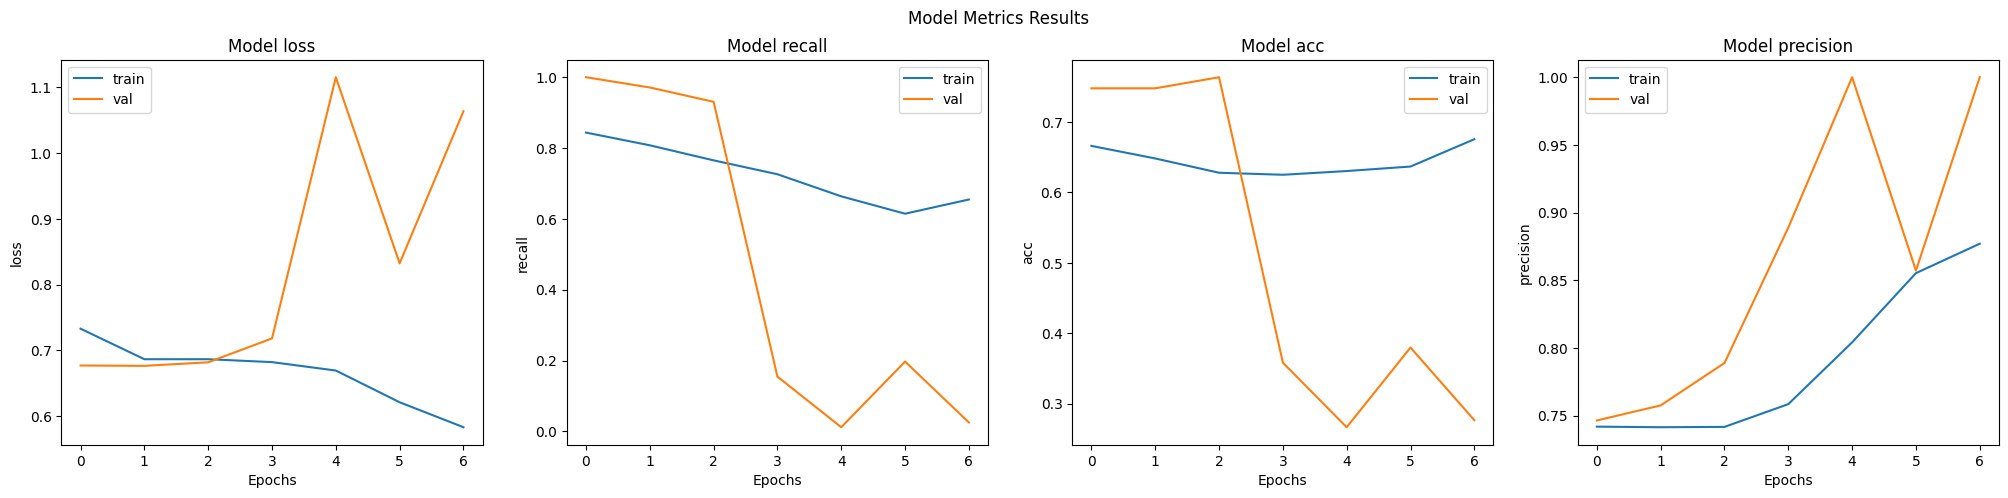

In [203]:
print("Model 6 with augmented data :\n")
eval_metrics(history6)


In [ ]:
train_labels, train_predictions = predict_results(model_5,train_gen_aug)
val_labels, val_predictions = predict_results(model_5,val_gen)

Training Confusion Matrices:



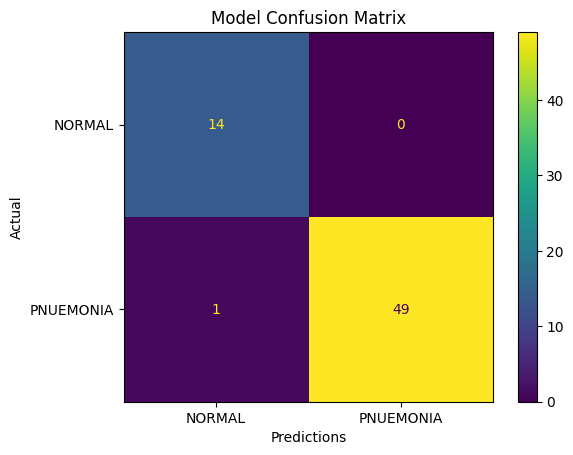

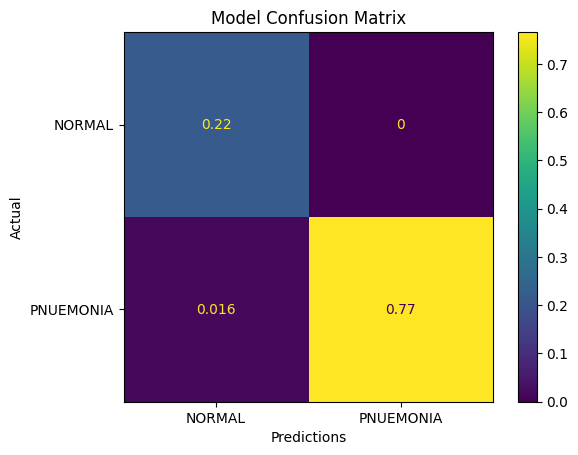

Validation Confusion Matrices:



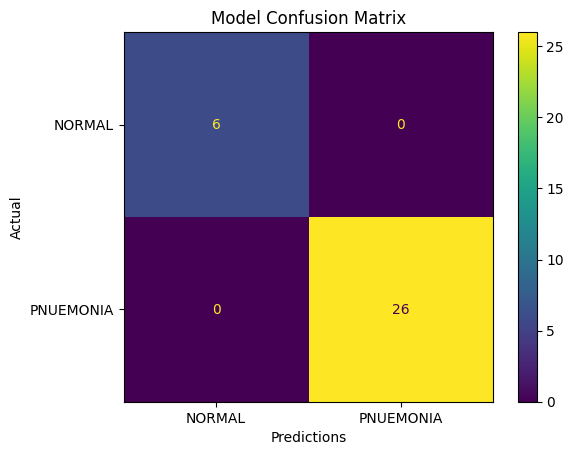

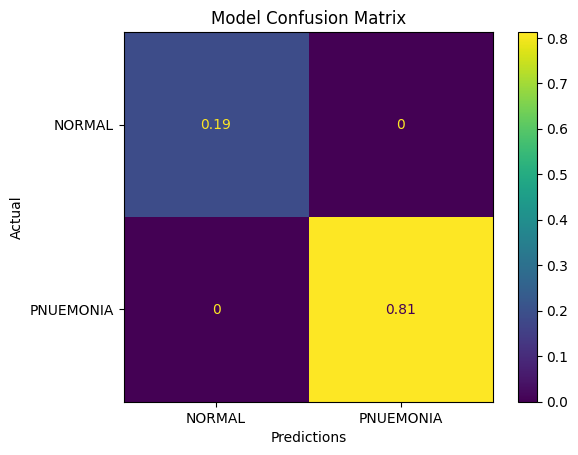

In [204]:
#Printing regular and normalized Confusion Matrices
print("Training Confusion Matrices:\n")
conf_matrix(train_labels,train_predictions, None)
conf_matrix(train_labels,train_predictions, "all")
print("Validation Confusion Matrices:\n")
conf_matrix(val_labels, val_predictions, None)
conf_matrix(val_labels, val_predictions, "all")

In [ ]:
#Training Classification Report
print("Training Classificaiton Report:\n")
eval_report(train_labels,train_predictions,train_gen,history6)

In [ ]:
#Training Classification Report
print("Validation Classificaiton Report:\n")
eval_report(val_labels,val_predictions,val_gen,history6)

### Model 6 Evaluation - Needs Updating

- Model Plots: The validation model has high variation and drastic overfitting
- Confusion Matrix: There is one FP and no FN.
- Report: The loss is a lot less with the validation set.
- Ths model wasn't bad. The validation's loss increased. The recall and f1score decreased from the previous model metrics.

- The next model will not use the augmented data.

# Model 7 - Learning Rate Optimization

Using gridsearch and keras wrappers to do some hyperparameter optimization
- learning_rate = [.001,.01,.1,.2] 

Description of the model hyperparameters and data parameters:

- **Model***
    - layers: 6 Conv2D each w/ MaxPooling2D, 3 Dense output layers
    - filters: 32,64,96 for Conv2D, 64,1 Dense layer
    - activation: Relu for all except Sigmoid for output layer
    - dropout:** .3 between the dense output layers
- **Model Compile**
    - loss: binary_crossentropy
    - optimizer:adam
    - **learning rate:** .001 (Default)
    - metrics: Accuracy,Recall,Precision
- **Fit**
    - data: train_gen, val_gen
    - train batchsize: 64
    - epochs: 45
    - early stopping : True
    - class weights: {0: 1.28, 1: 0.8205128205128205}
- **Additional Comments** 
    - Conv2D model is best for images
    - MaxPooling 2D is a downsampling strategy CNNs

In [ ]:
def buildModel(learning_rate):

    model= models.Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
           padding = 'same', input_shape=(224,224,3)),
    MaxPooling2D(pool_size=(2, 2), strides=2), 

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', 
           padding = 'same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Conv2D(filters=96, kernel_size=(3, 3), activation='relu', 
           padding = 'same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Conv2D(filters=96, kernel_size=(3, 3), activation='relu', 
           padding = 'same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', 
           padding = 'same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', 
           padding = 'same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),

    Flatten(),

    Dense(units=128, activation='relu',), 
    Dropout(.3),
    Dense(units=64, activation='relu'),
    Dropout(.3),    
    Dense(units=1, activation='sigmoid'),
    ])

    model.compile(loss='binary_crossentropy',
                  optimizer = Adam(learning_rate = learning_rate, ),
                    metrics=["acc","Recall","Precision"])

    
    return model

Learning rate determines the weights of out neural network with respect to the loss gradient. 

In [ ]:
learning_rate = [.001,.01,.1,.2]
parameters_3 = dict( learning_rate=learning_rate)
parameters_3

In [ ]:

classifier = KerasClassifier(build_fn=buildModel, batch_size = 64, epochs = 45, class_weight = class_weights)
#What hyperparameter we want to play with

grid_search = GridSearchCV(estimator = classifier,
                           error_score="raise",
                           param_grid = parameters_3,
                           refit = "Acc",
                           scoring = "accuracy",
                           cv = 3,return_train_score=True)
gs_3 = grid_search.fit(X_train, y_train, verbose = 1)

In [ ]:
print("Best: %f using %s" % (gs_3.best_score_, gs_3.best_params_))

This  .001 is the defult learning rate, nothing modifications and additons will be done.

---

# Transfer Learning

Explain transfer learning 
- VGG19 Model used
- Feature Extraction with Augmented data
- Feature Extraction without
- Fine Tuning

In [ ]:
# Transfer Learning V19
from keras.preprocessing import image
from PIL import Image

In [ ]:
cnn_base = VGG19(weights="imagenet", 
                 include_top=False, 
                 input_shape=(224, 224, 3))

In [ ]:
model_8 = models.Sequential()
model_8.add(cnn_base)
model_8.add(layers.Flatten())
model_8.add(layers.Dense(132, activation='relu'))
model_8.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
cnn_base.summary()

In [ ]:
model_8.summary()

In [ ]:
# You can check whether a layer is trainable (or alter its setting) through the layer.trainable attribute
for layer in model_8.layers:
    print(layer.name, layer.trainable)
    
# Similarly, you can check how many trainable weights are in the model
print(len(model_8.trainable_weights))

In [ ]:
# Freeze the model
cnn_base.trainable = False

In [ ]:
# You can check whether a layer is trainable (or alter its setting) through the layer.trainable attribute
for layer in model_8.layers:
    print(layer.name, layer.trainable)
    
# Similarly, you can check how many trainable weights are in the model
print(len(model_8.trainable_weights))

In [ ]:
model_8.compile(loss='binary_crossentropy',
                    optimizer= "adam",
                    metrics=["acc","Recall","Precision"]
                     )

In [ ]:
#Fitting with augmented training data
history8 = model_8.fit(train_gen_aug,batch_size=64,
                       epochs=45,
                       verbose = 2,
                       class_weight=class_weights,
                       validation_data=val_gen, 
                      callbacks = es) #stopping early because of time resources

Model 8 with augmented data :



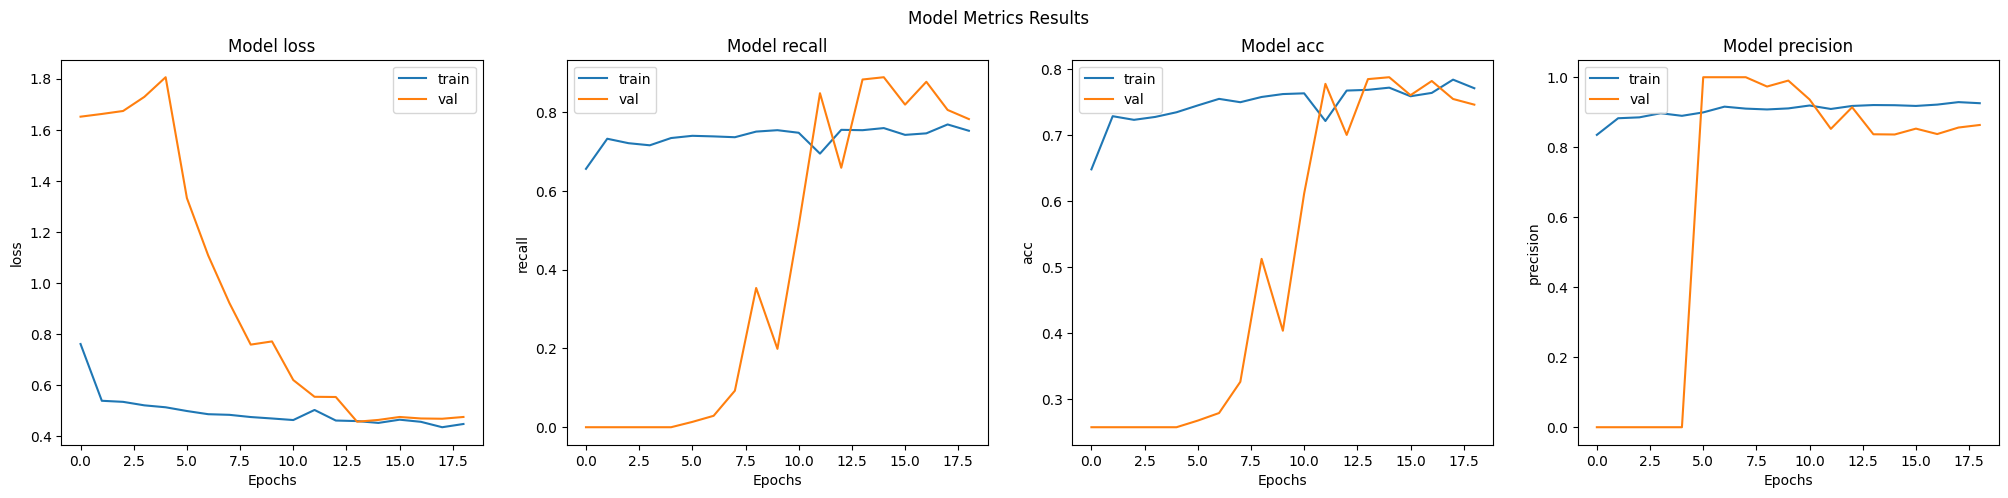

In [205]:
print("Model 8 with augmented data :\n")
eval_metrics(history8)

In [ ]:
train_labels, train_predictions = predict_results(model_8,train_gen_aug)
val_labels, val_predictions = predict_results(model_8,val_gen)

In [ ]:
#Printing regular and normalized Confusion Matrices
print("Training Confusion Matrices:\n")
conf_matrix(train_labels,train_predictions, None)
conf_matrix(train_labels,train_predictions, "all")
print("Validation Confusion Matrices:\n")
conf_matrix(val_labels, val_predictions, None)
conf_matrix(val_labels, val_predictions, "all")

In [ ]:
#Training Classification Report
print("Training Classificaiton Report:\n")
eval_report(train_labels,train_predictions,train_gen_aug,history8)

In [ ]:
#Training Classification Report
print("Validation Classificaiton Report:\n")
eval_report(val_labels,val_predictions,val_gen,history8)

## Transfer Model 10 Evaluation

In [ ]:
- update

---

# Transfer Model 9 without Augmented Data

In [173]:
#Copying model_8
model_9 = model_8

In [ ]:
#Fitting with non augmented data
history9 = model_9.fit(train_gen,batch_size=64,
                       epochs=45,
                       verbose = 2,
                       class_weight=class_weights,
                       validation_data=val_gen, 
                      callbacks = es) #stopping early because of time resources

Model 9 w/o augmented data :



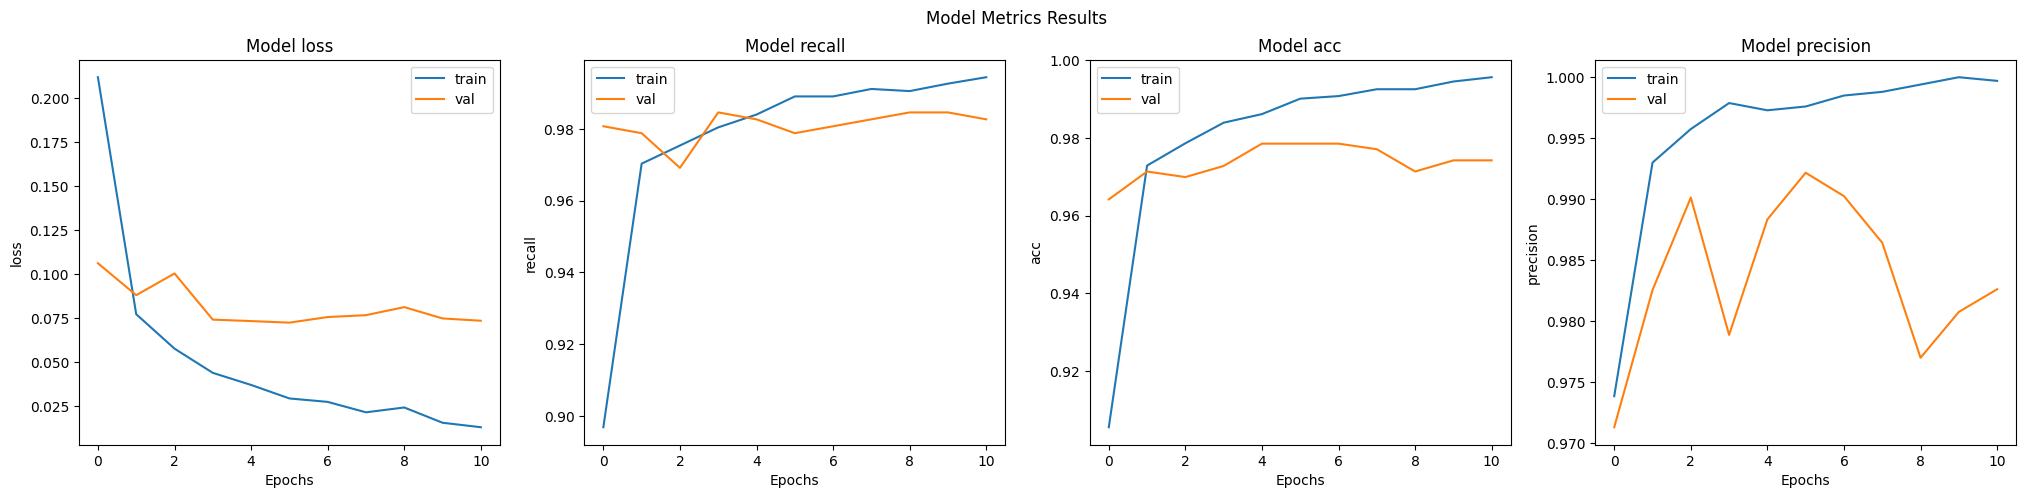

In [206]:
print("Model 9 w/o augmented data :\n")
eval_metrics(history9)

In [ ]:
train_labels, train_predictions = predict_results(model_9,train_gen)
val_labels, val_predictions = predict_results(model_9,val_gen)

Training Confusion Matrices:



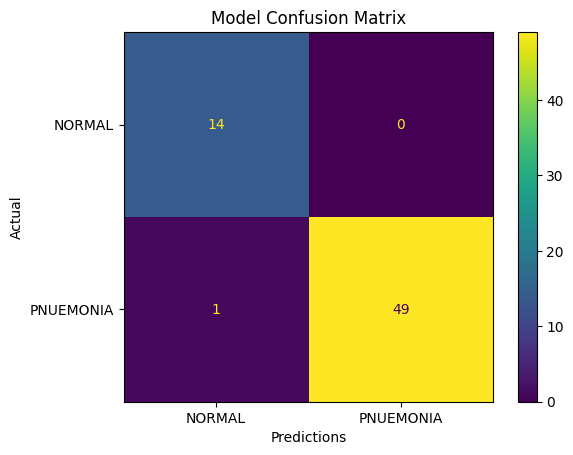

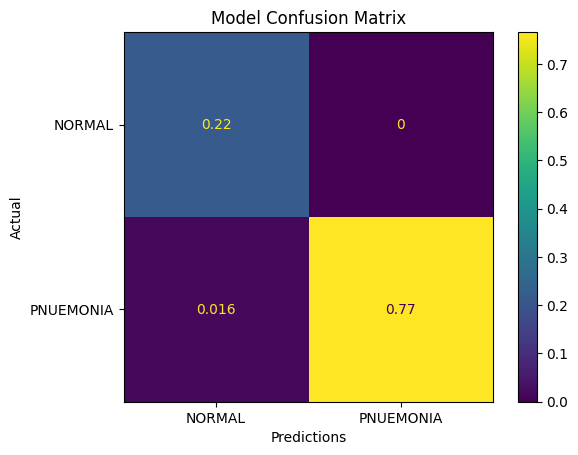

Validation Confusion Matrices:



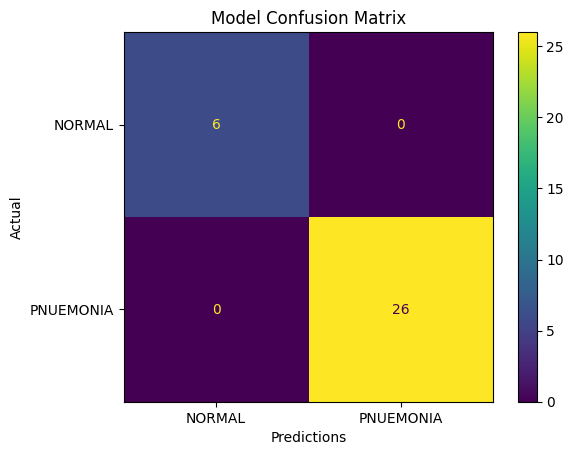

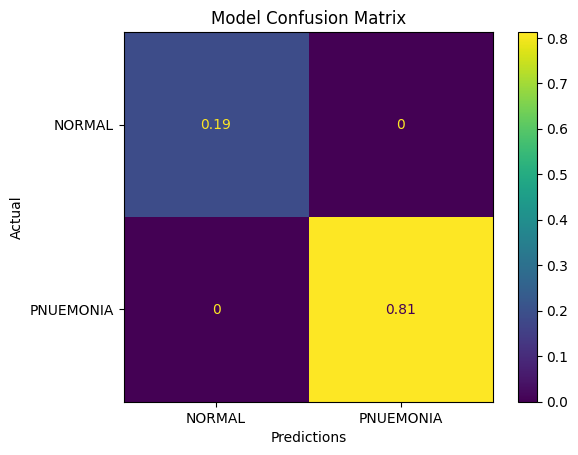

In [207]:
#Printing regular and normalized Confusion Matrices
print("Training Confusion Matrices:\n")
conf_matrix(train_labels,train_predictions, None)
conf_matrix(train_labels,train_predictions, "all")
print("Validation Confusion Matrices:\n")
conf_matrix(val_labels, val_predictions, None)
conf_matrix(val_labels, val_predictions, "all")

In [208]:
#Training Classification Report
print("Training Classificaiton Report:\n")
eval_report(train_labels,train_predictions,train_gen,history9)

Training Classificaiton Report:

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.97        14
         1.0       1.00      0.98      0.99        50

    accuracy                           0.98        64
   macro avg       0.97      0.99      0.98        64
weighted avg       0.99      0.98      0.98        64



68/68 [==============================] - 23s 335ms/step - loss: 0.0572 - acc: 0.9817 - recall: 0.9829 - precision: 0.9925
Loss: 0.0572


In [ ]:
#Training Classification Report
print("Validation Classificaiton Report:\n")
eval_report(val_labels,val_predictions,val_gen,history9)

## Transfer Model 9 Evaluation

---

# Transfer Model 10 w/ Fine Tuning

Removing a layer

In [171]:
model_10 = model_9
cnn_base_tuned = cnn_base

In [ ]:
model_10.summary()

In [ ]:
cnn_base_tuned.trainable = True

In [ ]:
cnn_base_tuned.summary()

In [ ]:
cnn_base_tuned.trainable = True
set_trainable = False
for layer in cnn_base_tuned.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model_10.compile(loss='binary_crossentropy',
                    optimizer= "adam",
                    metrics=["acc","Recall","Precision"]
                     )

In [ ]:
history10 = model_10.fit(train_gen,batch_size=64,
                       epochs=45,
                       verbose = 2,
                       class_weight=class_weights,
                       validation_data=val_gen, 
                      callbacks = es) #stopping early because of time resources

Model 9 w/o augmented data :



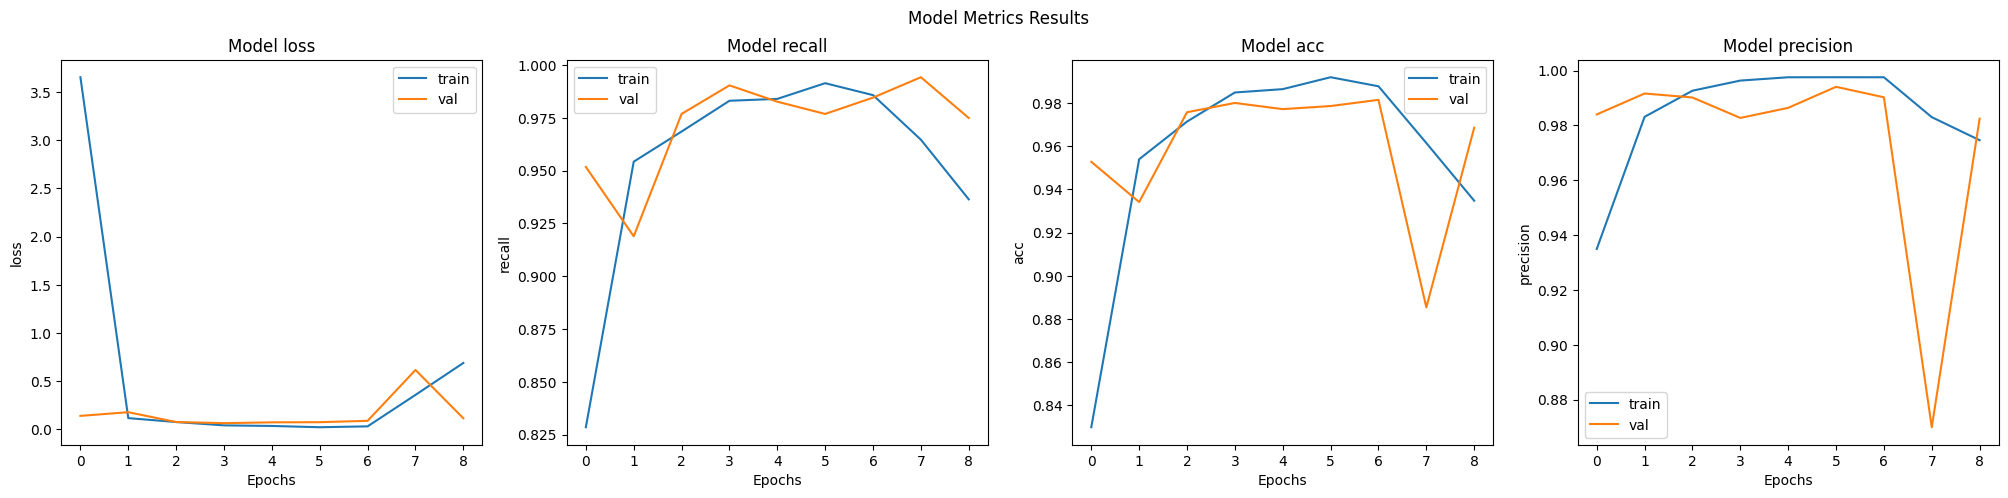

In [209]:
print("Model 9 w/o augmented data :\n")
eval_metrics(history10)

In [ ]:
train_labels, train_predictions = predict_results(model_10,train_gen)
val_labels, val_predictions = predict_results(model_10,val_gen)

In [ ]:
#Printing regular and normalized Confusion Matrices
print("Training Confusion Matrices:\n")
conf_matrix(train_labels,train_predictions, None)
conf_matrix(train_labels,train_predictions, "all")
print("Validation Confusion Matrices:\n")
conf_matrix(val_labels, val_predictions, None)
conf_matrix(val_labels, val_predictions, "all")

In [ ]:
#Training Classification Report
print("Training Classificaiton Report:\n")
eval_report(train_labels,train_predictions,train_gen,history10)

In [ ]:
#Training Classification Report
print("Validation Classificaiton Report:\n")
eval_report(val_labels,val_predictions,val_gen,history10)

## Transfer Model 10 Evaluation

---

# Final Model

## Best Model

## Prediction

# Model Explainer

In [ ]:
# Add verbage

In [174]:
def img_array_pred(y_label, X_image_array,model,num):
    """ Inputing the data set and model to retrieve an image and prediciton results. This supports input into the 
    Lime Explainer lodule"""

    #num = np.random.randint(0,20) If want to later generate random pictures
    
    label = y_label[num]
    img = X_image_array[num]

    # Get Model Prediction
    pred = model.predict(np.array([img]))
    pred_round = np.round(pred,1)

    # Print True and Predicted Image
    if pred_round == 0:
        print('Image is Normal (0)!')
    else:
        print('Image is Pneumonia (1)')

    if label == 0:
        print('Image predicted as Normal (0)!')
    else:
        print('Image predicted as Pneumonia (1)!')

    print (f"Image Index {num} was chosen.")    
    
    return array_to_img(img)

## Analysis of True Positive Image

1/1 [==============================] - 0s 66ms/step
Image is Pneumonia (1)
Image predicted as Pneumonia (1)!
Image Index 4 was chosen.


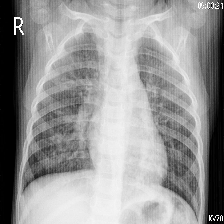

In [175]:
#Prints Prediction, True Label, Associate Predicted Image and Index
img = img_array_pred(y_train, X_train,model_5,4 )
img

In [176]:
explainer = lime_image.LimeImageExplainer()

In [177]:
explanation = explainer.explain_instance(X_train[4].astype('double'), model_5.predict,  
                                         top_labels=3, hide_color=0, num_samples=1000,)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


In [190]:
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=20, hide_rest=False)

(-0.5, 223.5, 223.5, -0.5)

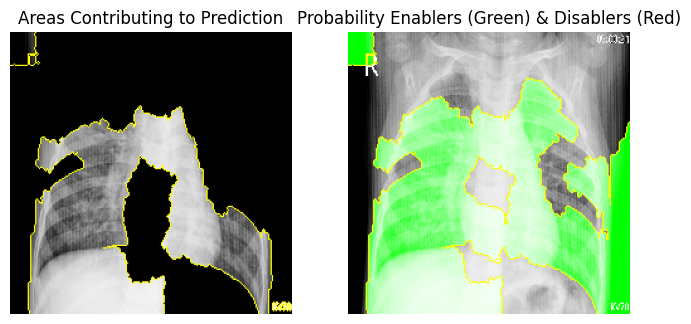

In [179]:
fig, axes = plt.subplots(1,2,figsize=(8,8))
axes[0].imshow(mark_boundaries(temp_1, mask_1))
axes[0].set_title("Areas Contributing to Prediction")
axes[1].imshow(mark_boundaries(temp_2, mask_2))
axes[1].set_title("Probability Enablers (Green) & Disablers (Red)")
axes[0].axis('off')
axes[1].axis('off')
#plt.savefig('Lime_TP.png')

## Analysis of  Negative Image

1/1 [==============================] - 0s 11ms/step
Image is Pneumonia (1)
Image predicted as Normal (0)!
Image Index 1 was chosen.


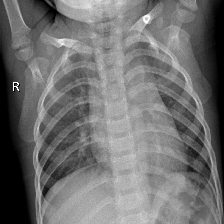

In [183]:
img2 = img_array_pred(y_train, X_train,model_5,1 )
img2

In [184]:
explainer = lime_image.LimeImageExplainer()
explanation2 = explainer.explain_instance(X_train[1].astype
                                          ("double"), model_5.predict,  
                                         top_labels=3, hide_color=None, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 9ms/step


In [185]:

temp_1, mask_1 = explanation2.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
temp_2, mask_2 = explanation2.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=15, hide_rest=False)

(-0.5, 223.5, 223.5, -0.5)

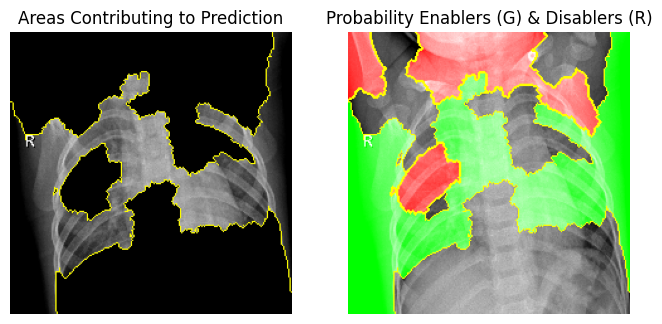

In [189]:
fig, axes = plt.subplots(1,2,figsize=(8,8))
axes[0].imshow(mark_boundaries(temp_1, mask_1))
axes[0].set_title("Areas Contributing to Prediction")
axes[1].imshow(mark_boundaries(temp_2, mask_2))
axes[1].set_title("Probability Enablers (G) & Disablers (R)")
axes[0].axis('off')
axes[1].axis('off')
#plt.savefig('Lime_FN.png')

# Conclusion

## Reccommmendation

- Usage
- Strategy


## Limitations

In [187]:
##